### From Chapter 3 of Understanding Deep Learning Book

> Figure 3.3 shows the flow of computation that creates the function in figure 3.2a. Each hidden unit contains a linear function θ•0 + θ•1x of the input, and that line is clipped by the ReLU function a[•] below zero. **==The positions where the three lines cross zero become the three “joints” in the final output.==** The three clipped lines are then weighted by ϕ1, ϕ2, and ϕ3, respectively. Finally, the offset ϕ0 is added, which controls the overall height of the final function

### Figure 3.2
![figure](exercises/exer_screenshots/fig3132.png)

### Figure 3.3
![figure 3.3](exercises/exer_screenshots/fig3.3.png)

In [46]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (1, n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(net_sizes, key):
  keys = random.split(key, len(net_sizes))
  return [
     random_layer_params(m, n, k) 
     for (m,n), k in zip(net_sizes, keys)
   ]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [47]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input
    count = 0
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
        print(count)
        count += 1
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

In [48]:
import numpy as np
import math

def generate_sine_data(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.sin(X)
  return X,y

def update_weights(params, x, y, learning_rate):
  grads = grad(loss_func)(params, x, y)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_samples, num_epochs, step_display):
  learning_rate = 0.01
  X,y = generate_sine_data(num_samples)

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, X, y)
    params = update_weights(params, X, y, learning_rate)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def parameter_sizes(params):
  layer_depth = len(params)
  for layer_num, layer in enumerate(params, start=1):
    weight_dims = layer[0].shape
    bias_dims = layer[1].shape
    print('weights_dtype = ', layer[0].dtype)
    print('bias_dtype = ', layer[1].dtype)

    print(f'[{layer_num}/{layer_depth}] weight_dims = {weight_dims}, bias_dims = {bias_dims}')


In [53]:
parameter_sizes(params)

weights_dtype =  float32
bias_dtype =  float32
[1/2] weight_dims = (1, 12), bias_dims = (1, 12)
weights_dtype =  float32
bias_dtype =  float32
[2/2] weight_dims = (12, 1), bias_dims = (1, 1)


In [51]:
import matplotlib.pyplot as plt

def plot_first_activations(params, X, y, epoch_round):

    linear_01 = X @ params[0][0] + params[0][1]
    activation = relu(linear_01)
    linear_01 = np.array(linear_01)
    activation = np.array(activation)

    final_weight = params[1][0].reshape(-1)
    final_offset = params[1][1].reshape(-1)
    
    figsize = (15,5)
    linear_columns = linear_01.shape[1]
    fig, axs = plt.subplots(4, linear_columns, figsize=figsize)

    y_min = -2 
    y_max = 2
    X_flat = X.reshape(-1)

    for linear_col in range(linear_columns):
        axs[0, linear_col].set_title(f'w{linear_col}, b{linear_col}')
        axs[0, linear_col].plot(X_flat, linear_01[:, linear_col].reshape(-1))
        axs[0, linear_col].set_ylim([y_min, y_max])
        axs[0, linear_col].set_xlim([0, 2 * math.pi])
        
        axs[1, linear_col].plot(X_flat, activation[:, linear_col])
        axs[1, linear_col].set_ylim([y_min, y_max])
        axs[1, linear_col].set_xlabel('X')
        axs[1, linear_col].set_xlim([0, 2 * math.pi])

        axs[2, linear_col].axhline(y=final_weight[linear_col], linestyle='-', color='green')
        axs[3, linear_col].axhline(y=final_offset[linear_col], linestyle='.', color='pink')
        
        if linear_col == 0:
            axs[0, linear_col].set_ylabel('X @ W + b')
            axs[1, linear_col].set_ylabel('ReLU(X @ W + b)')
            axs[2, linear_col].set_ylabel('Final Weight')
            axs[3, linear_col].set_ylabel('Final Offset')

    fig.suptitle(f'Epoch Round: {epoch_round}')
    plt.show()

    y_pred = predict(params, X)
    plt.figure(figsize=figsize)
    plt.title(f'Prediction VS Target - Epoch Round: {epoch_round}')
    plt.plot(X_flat, y_pred, color='gray', label='prediction')
    plt.plot(X_flat, y, color='red', label='target')
    plt.legend()
    plt.show()

    




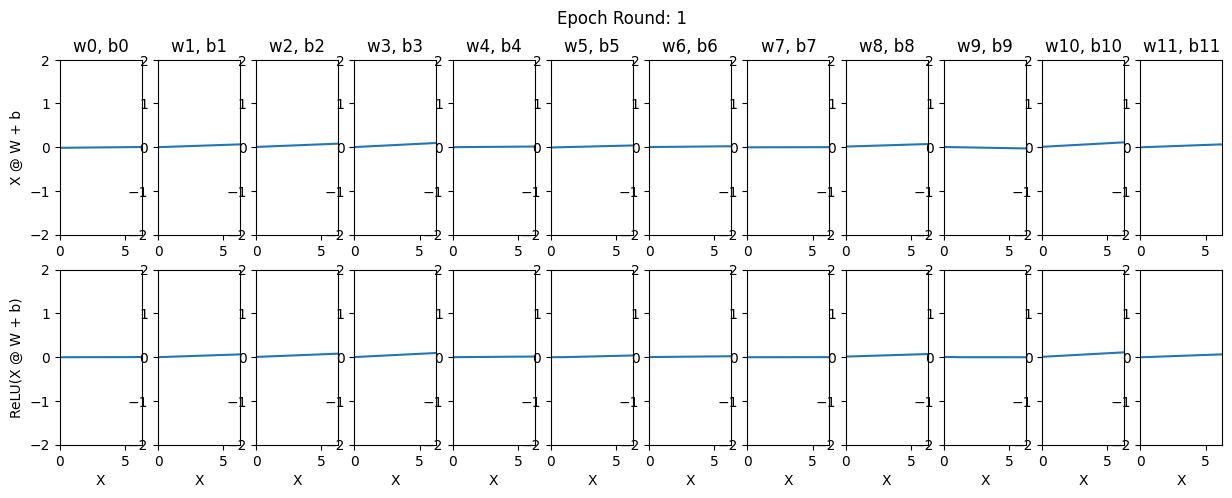

0


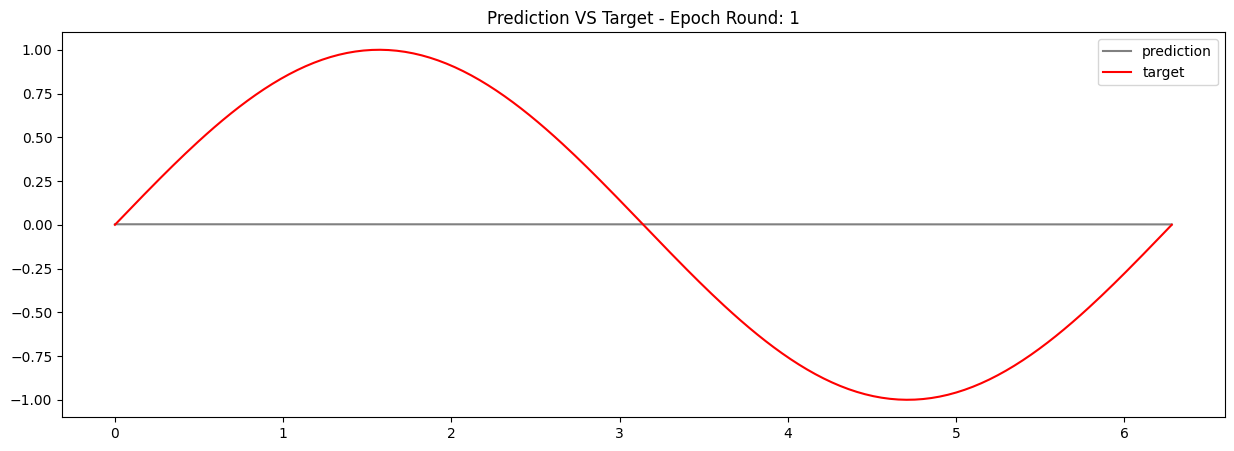

[1024/1024] Loss: 0.11746898293495178


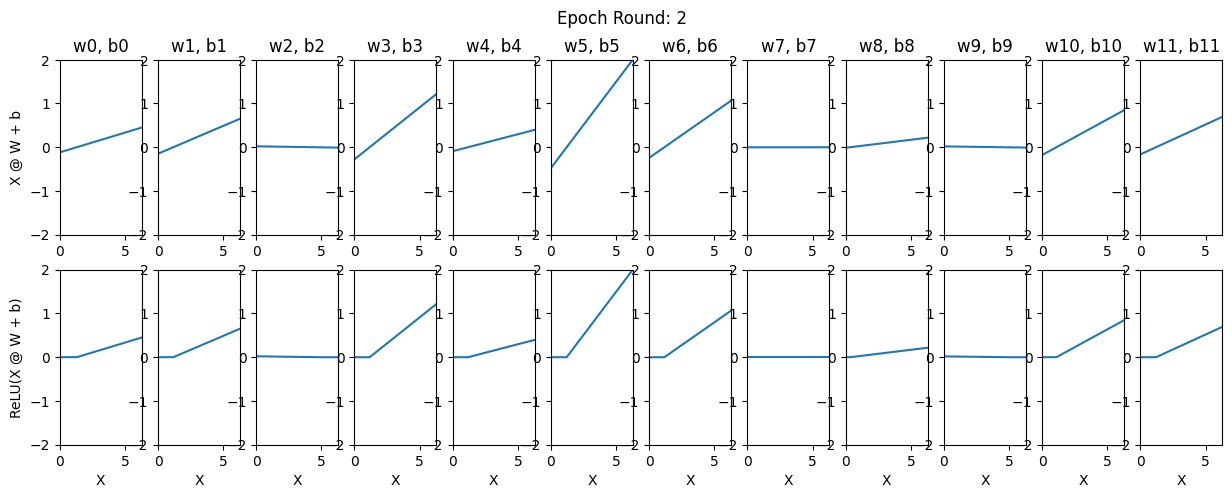

0


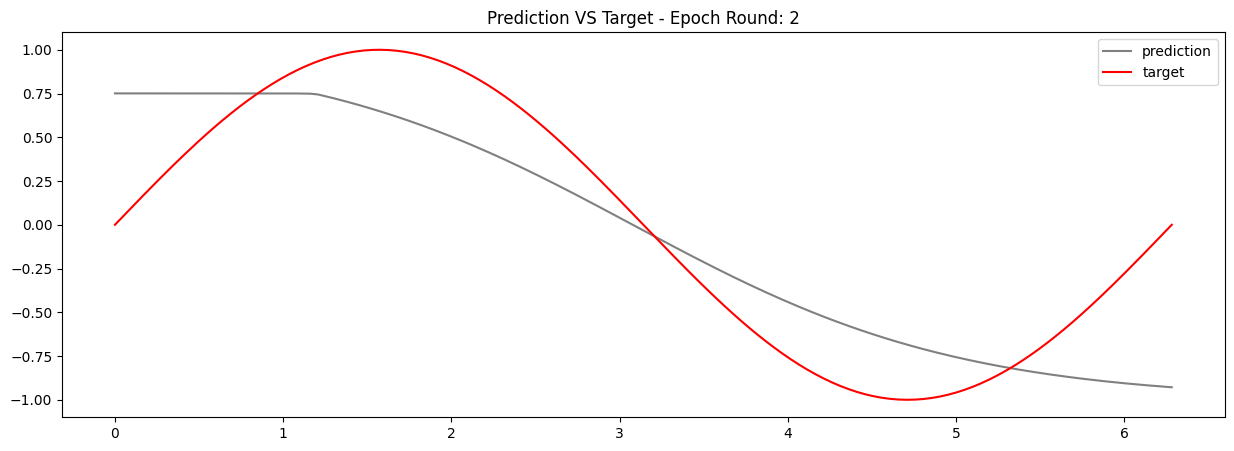

[1024/1024] Loss: 0.09595748037099838


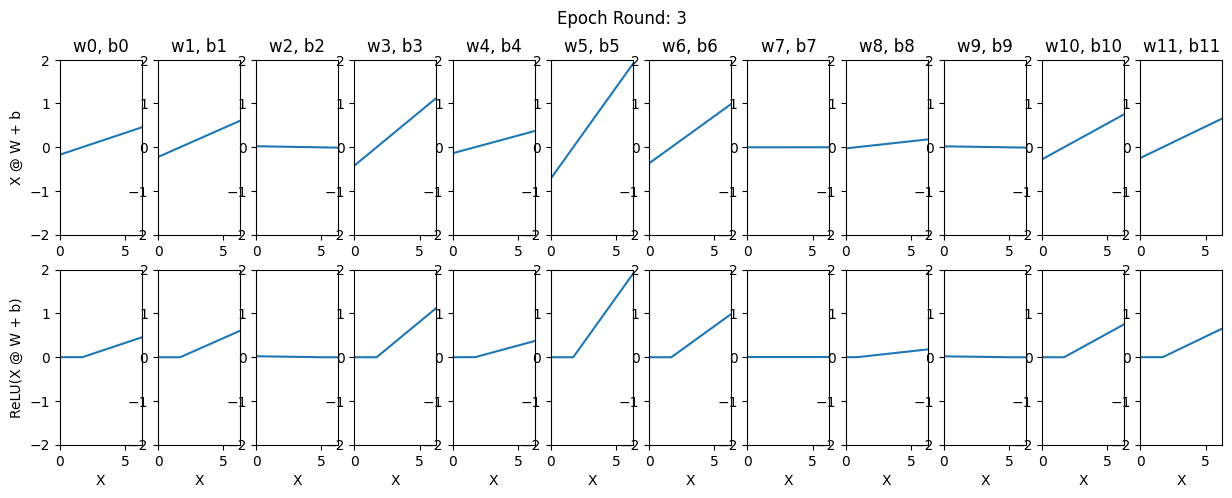

0


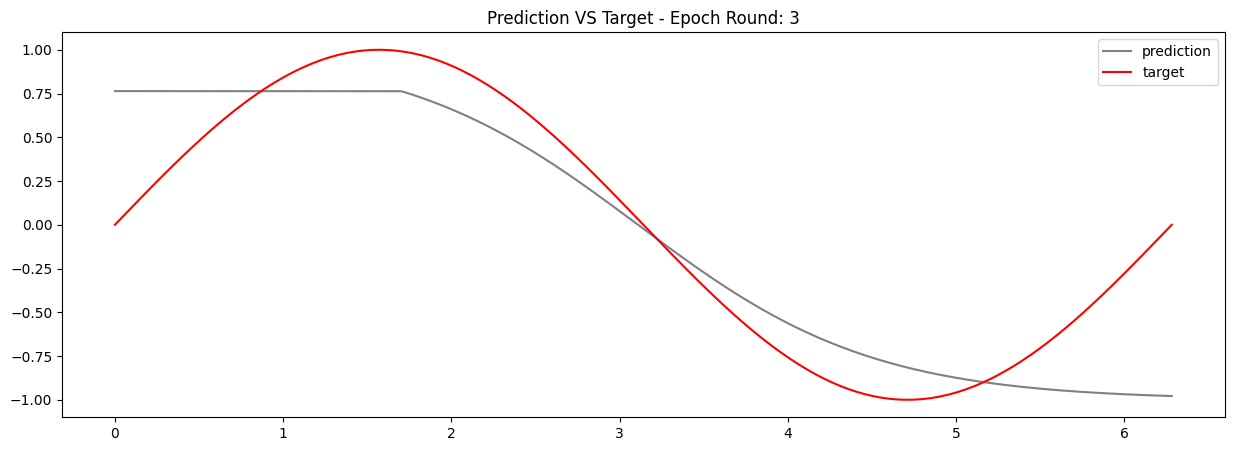

[1024/1024] Loss: 0.09032965451478958


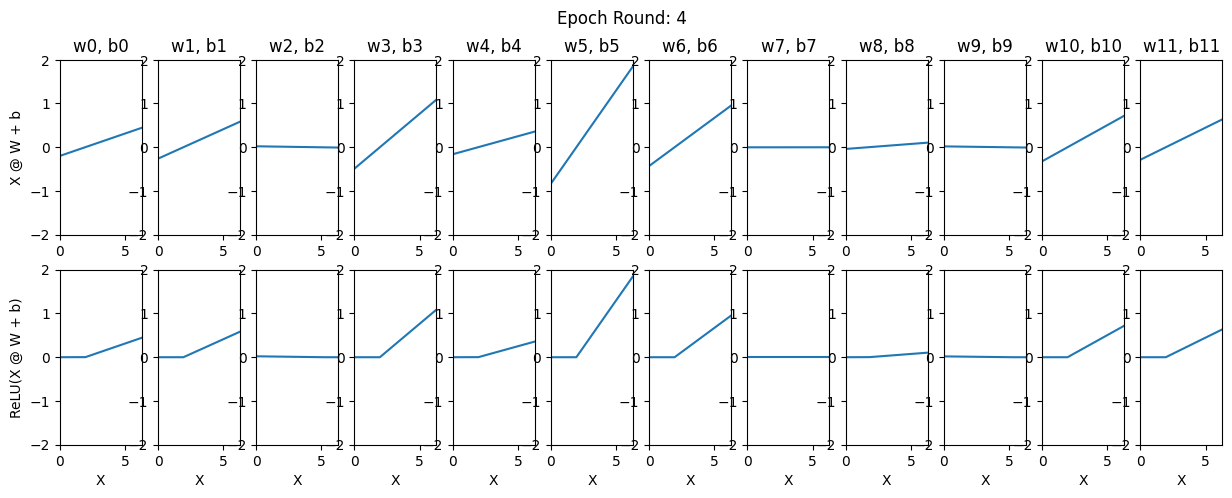

0


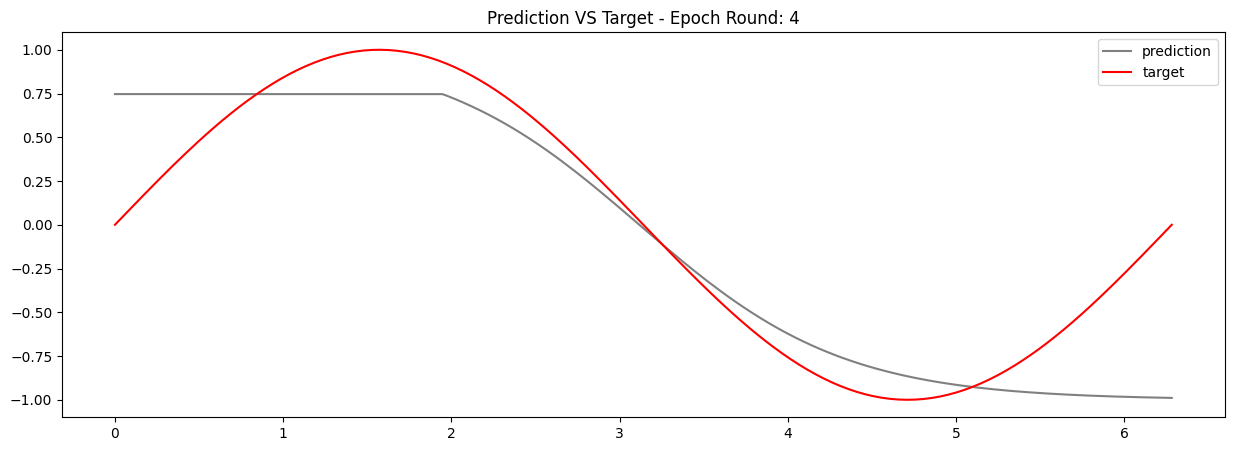

[1024/1024] Loss: 0.08845363557338715


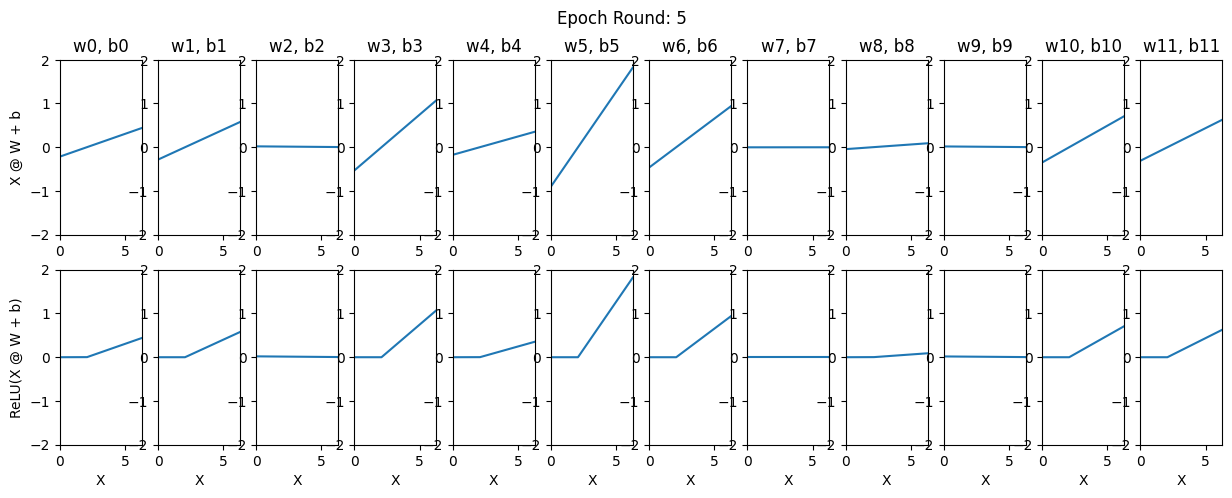

0


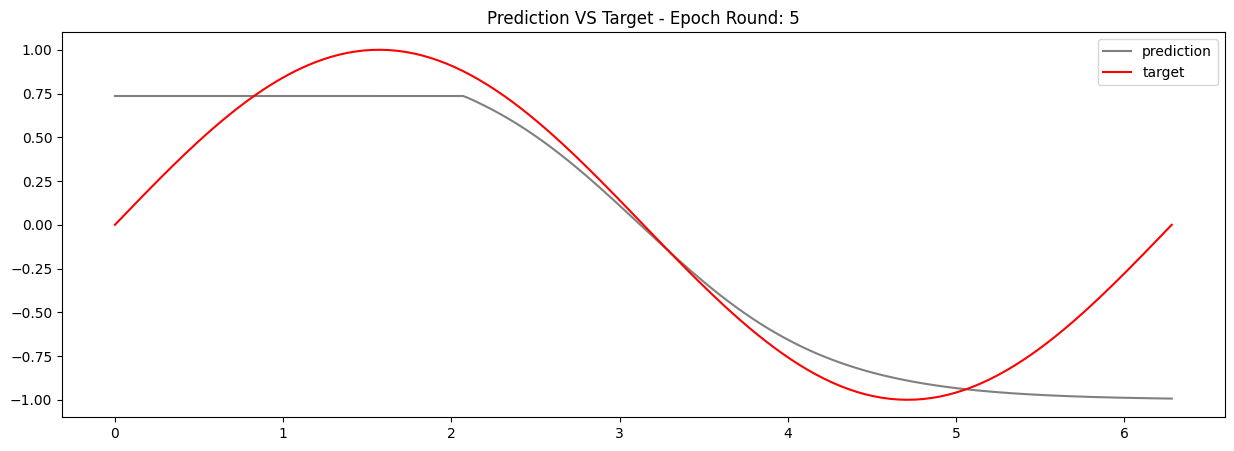

[1024/1024] Loss: 0.08772414177656174


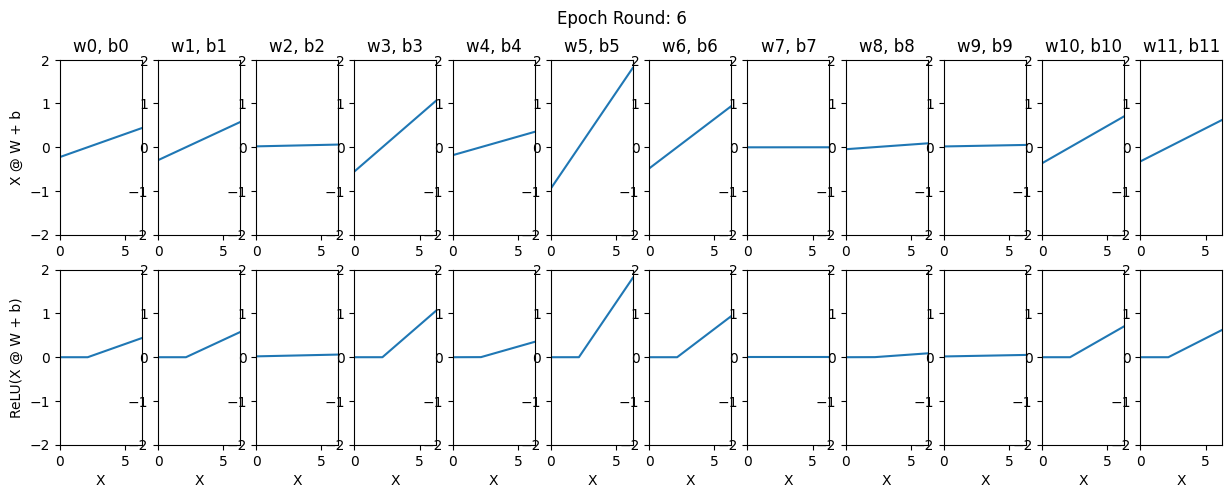

0


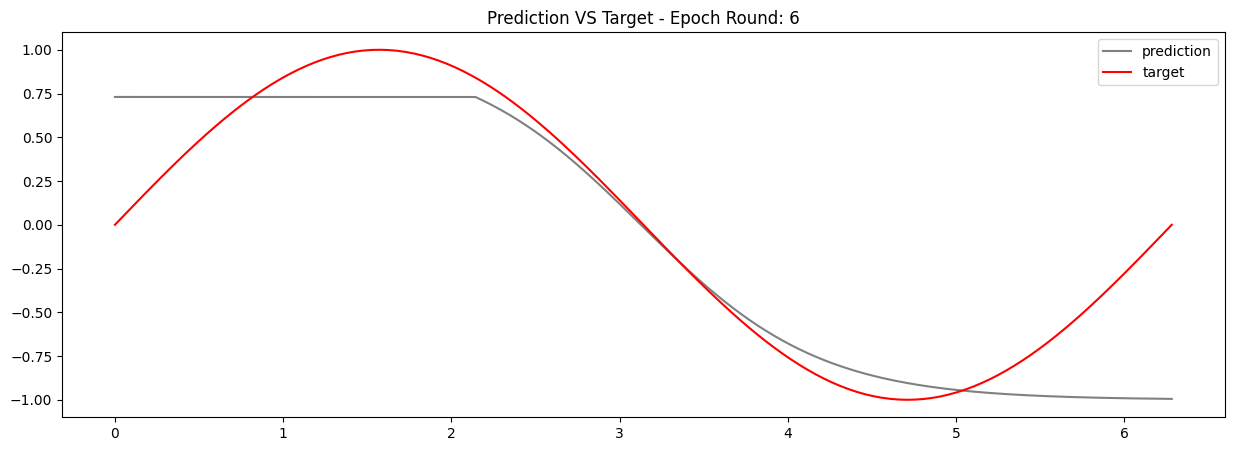

[1024/1024] Loss: 0.08739253878593445


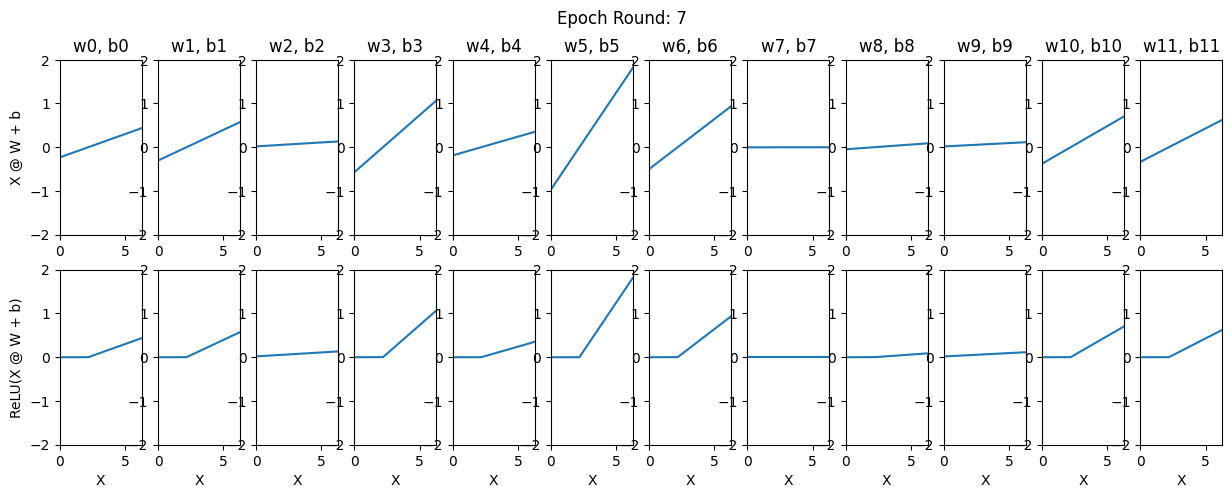

0


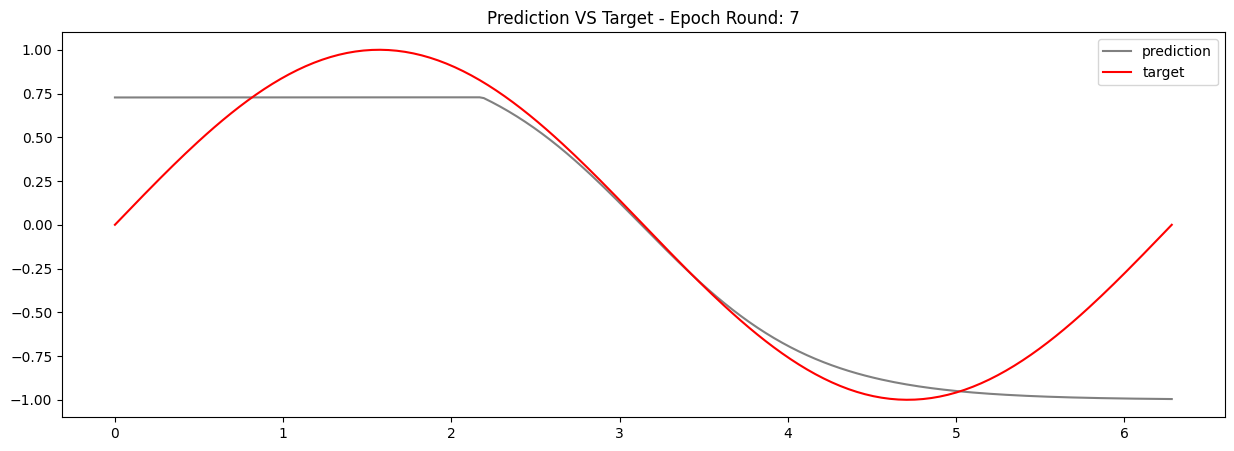

[1024/1024] Loss: 0.0871739462018013


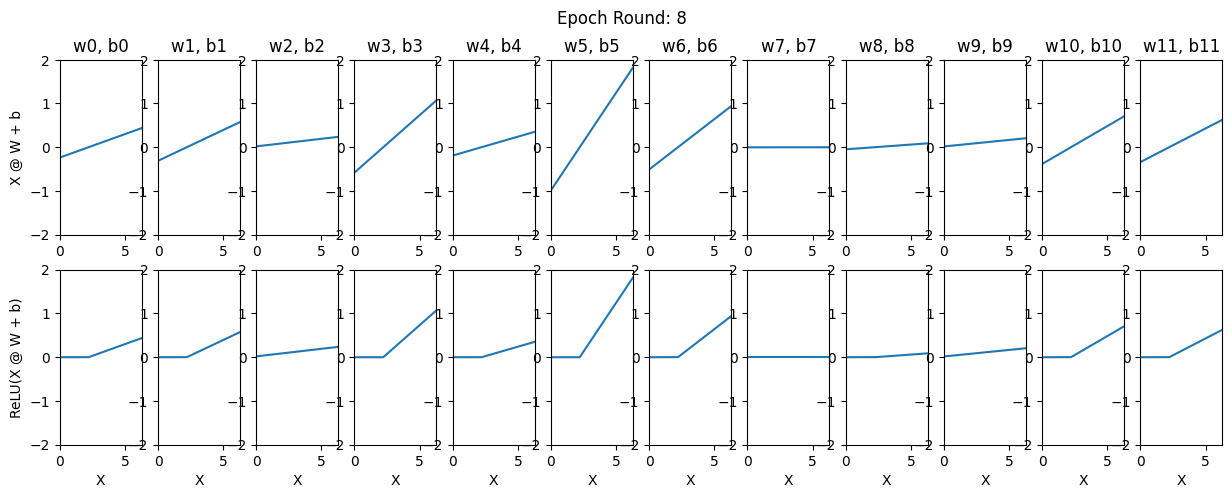

0


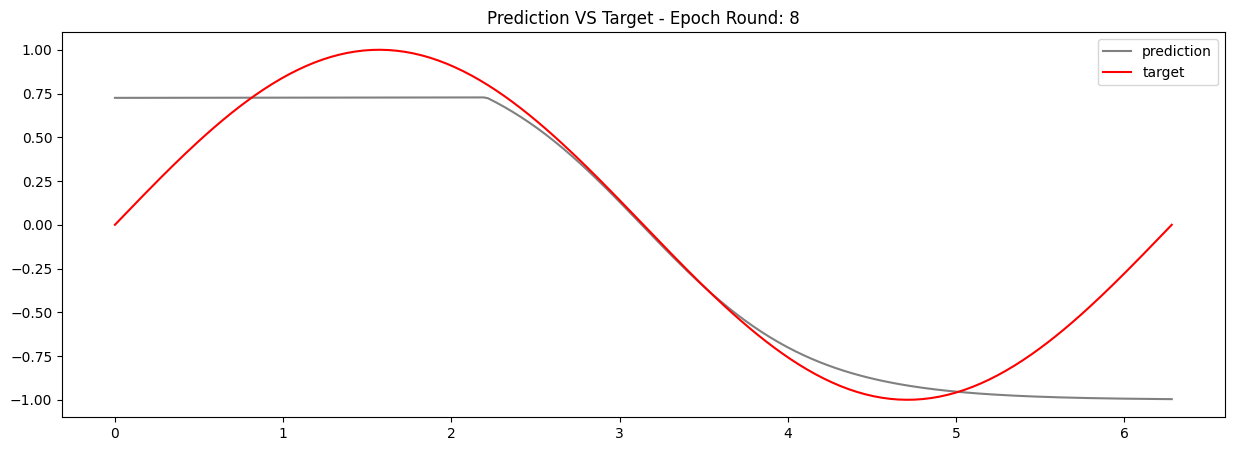

[1024/1024] Loss: 0.08687133342027664


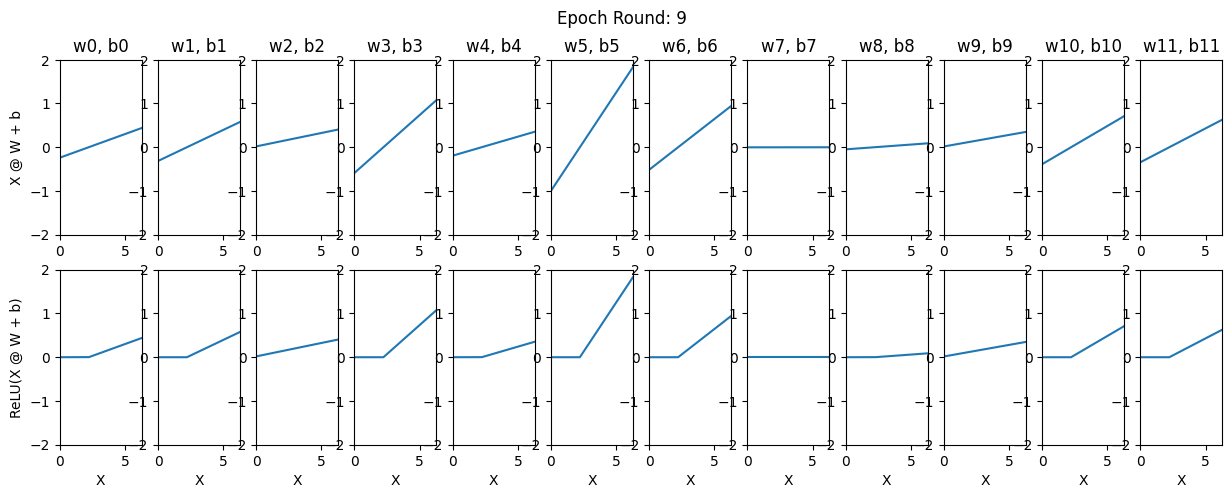

0


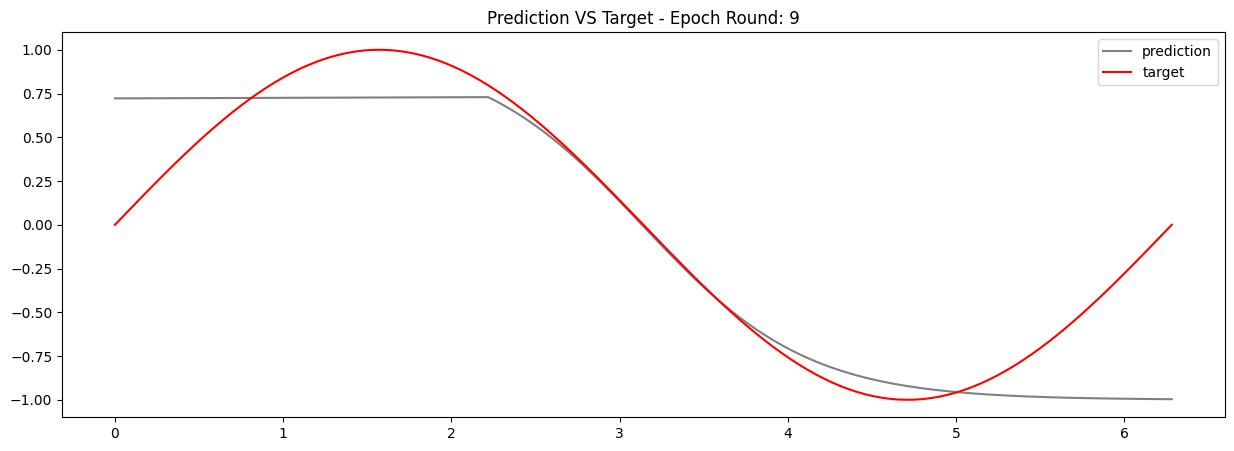

[1024/1024] Loss: 0.08617682754993439


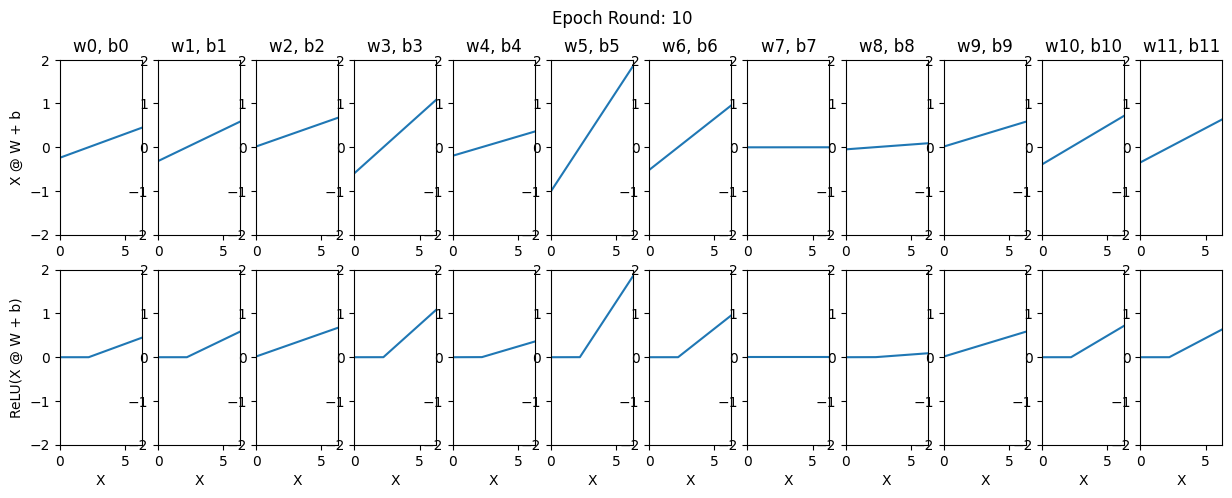

0


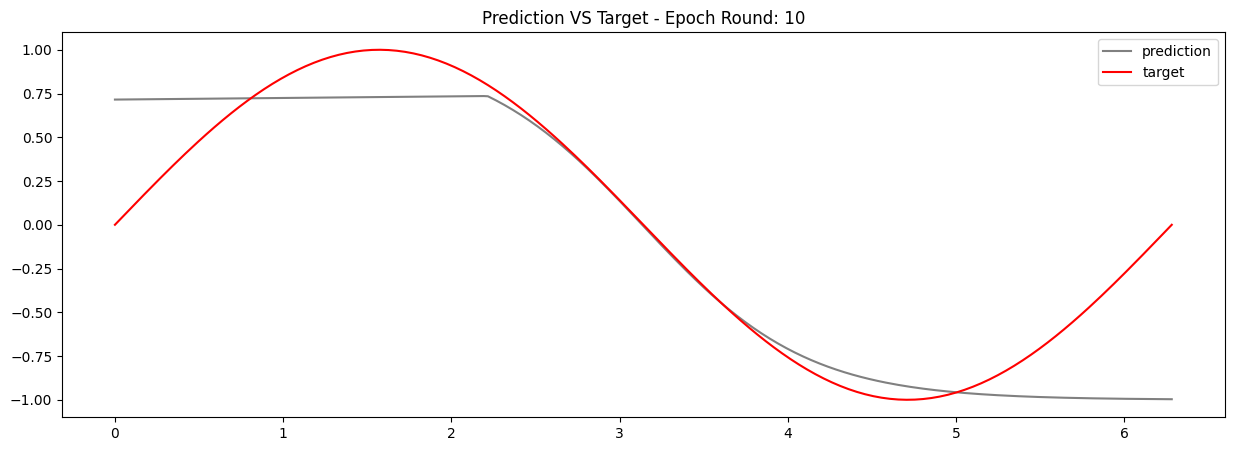

[1024/1024] Loss: 0.0845150277018547


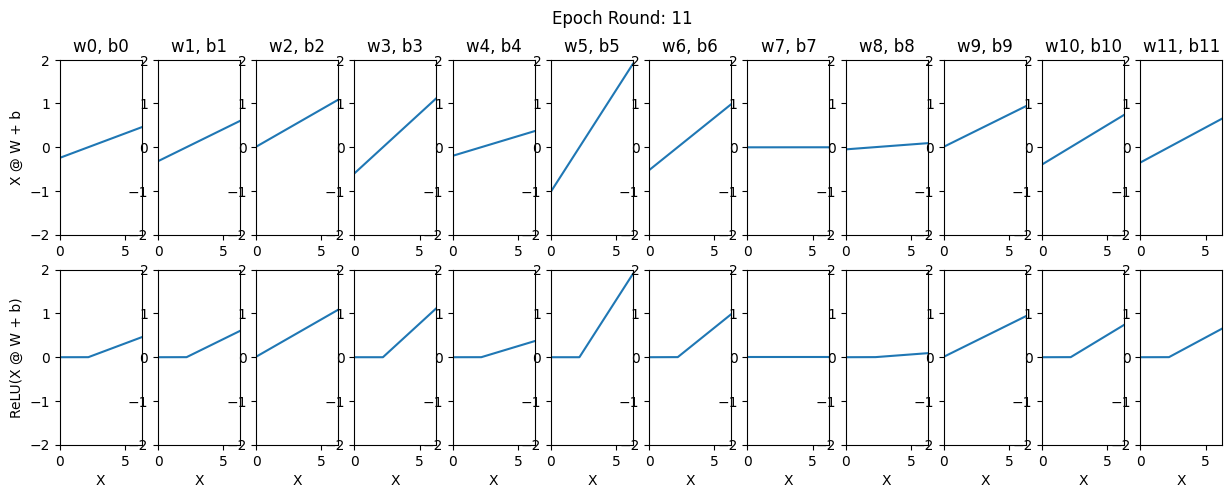

0


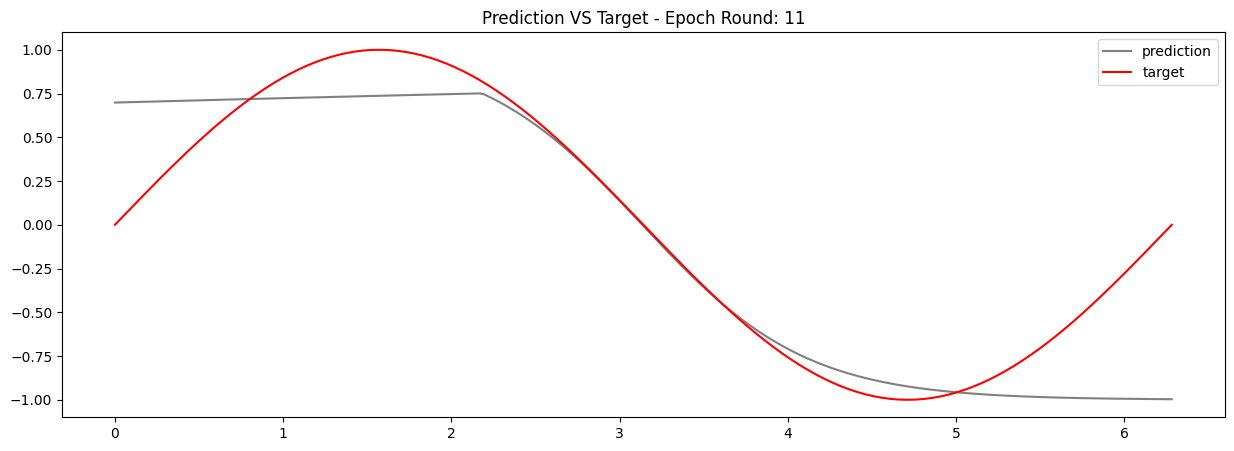

[1024/1024] Loss: 0.0811828225851059


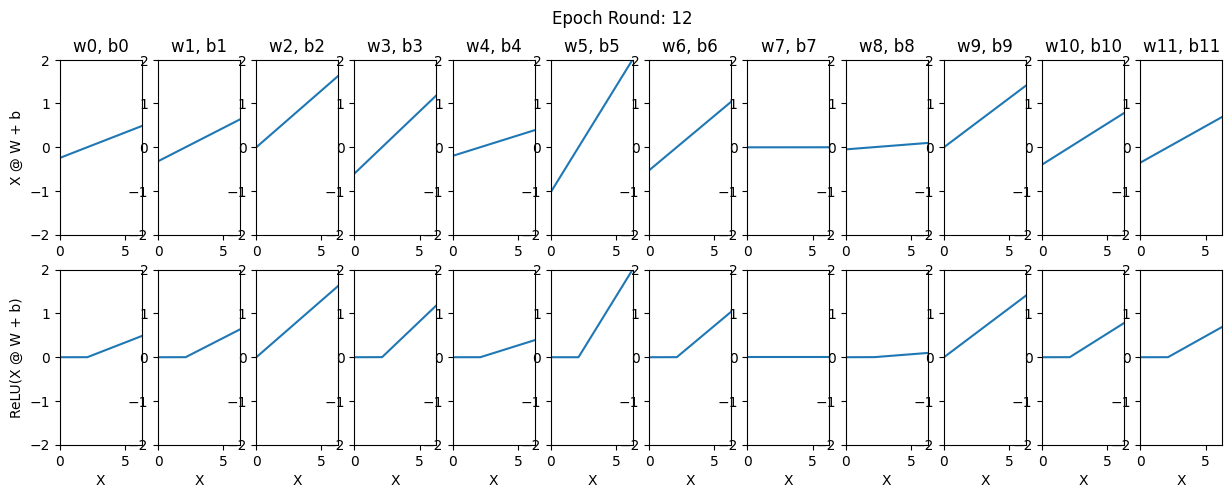

0


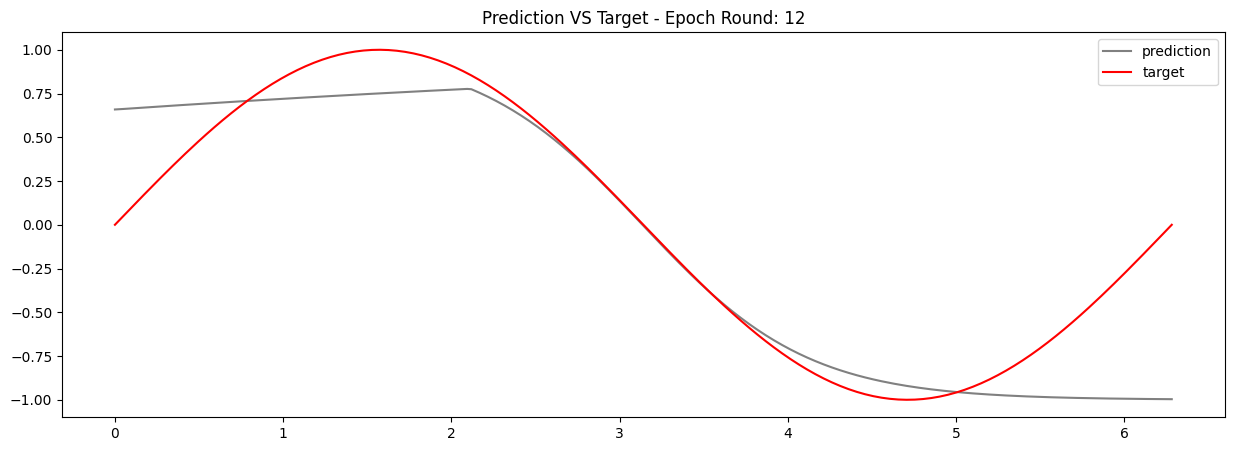

[1024/1024] Loss: 0.07617567479610443


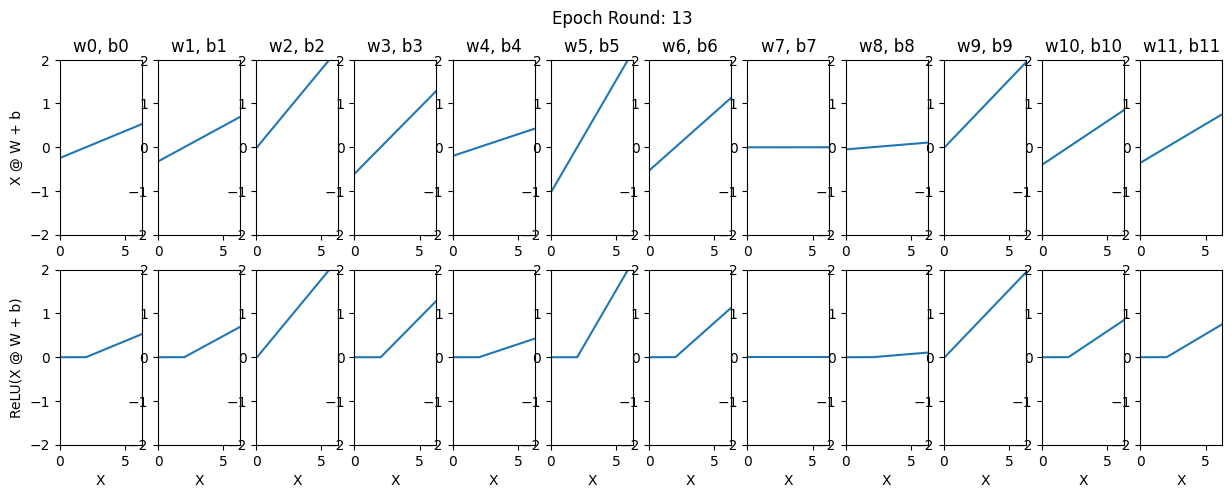

0


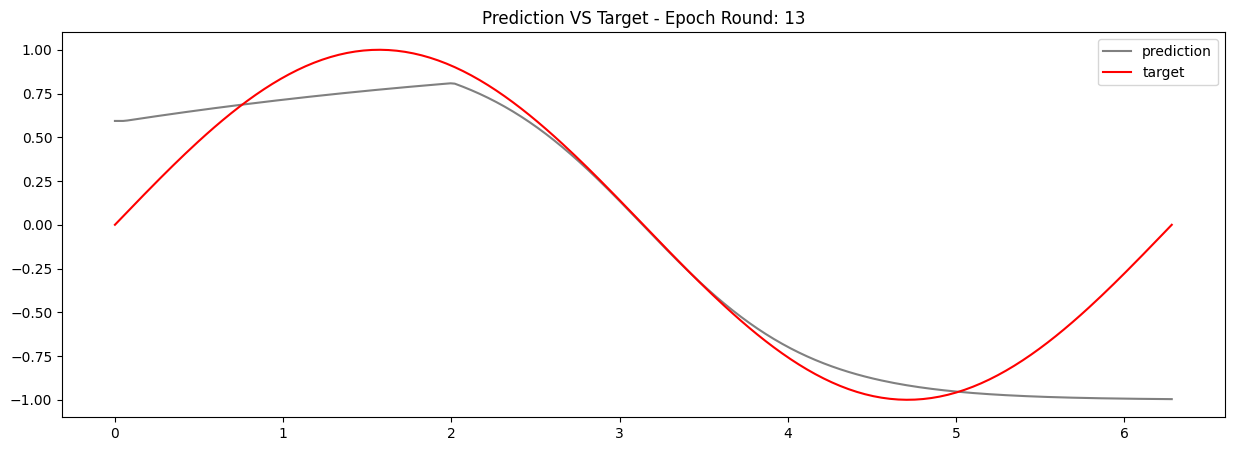

[1024/1024] Loss: 0.07062278687953949


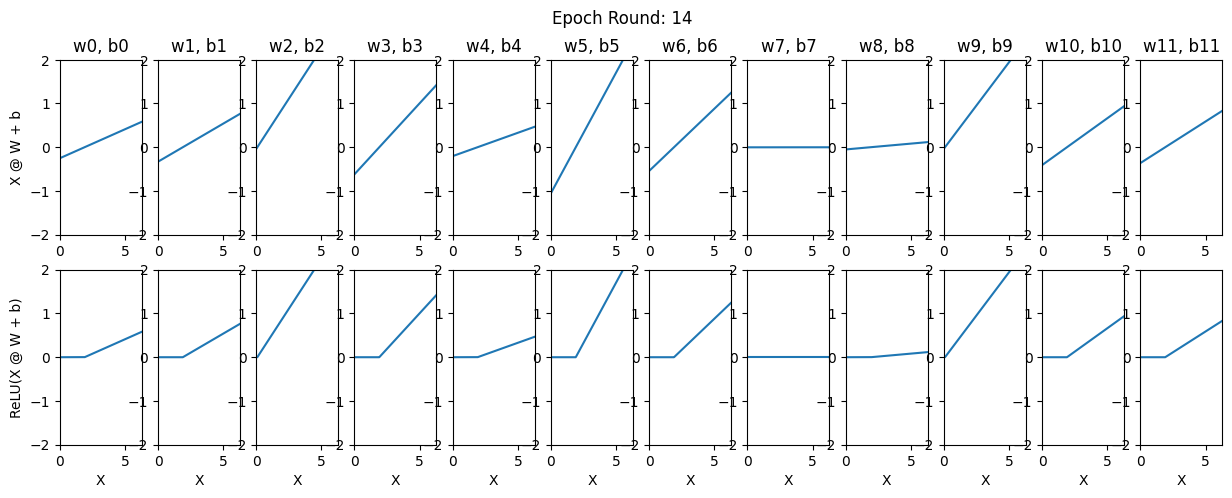

0


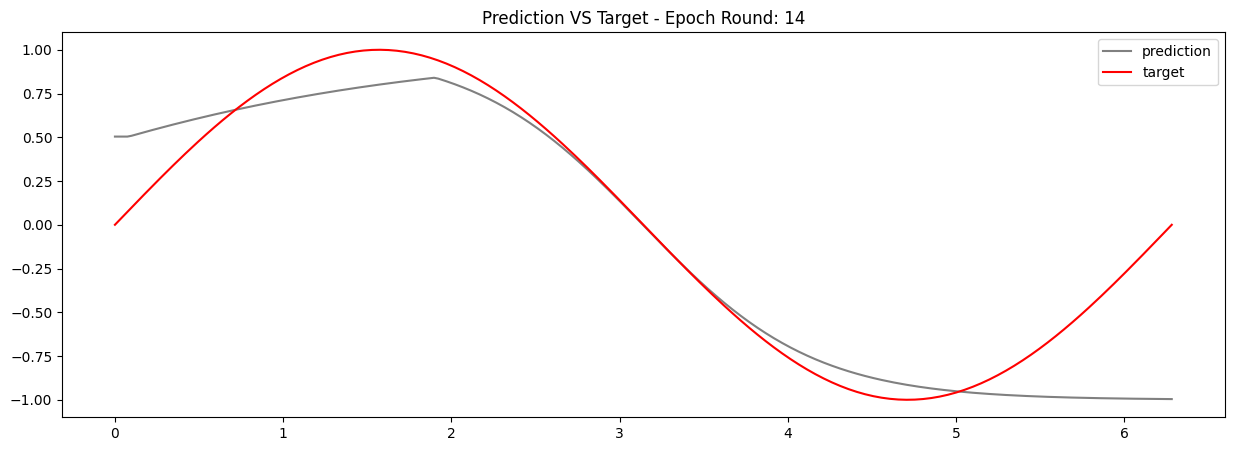

[1024/1024] Loss: 0.06587757915258408


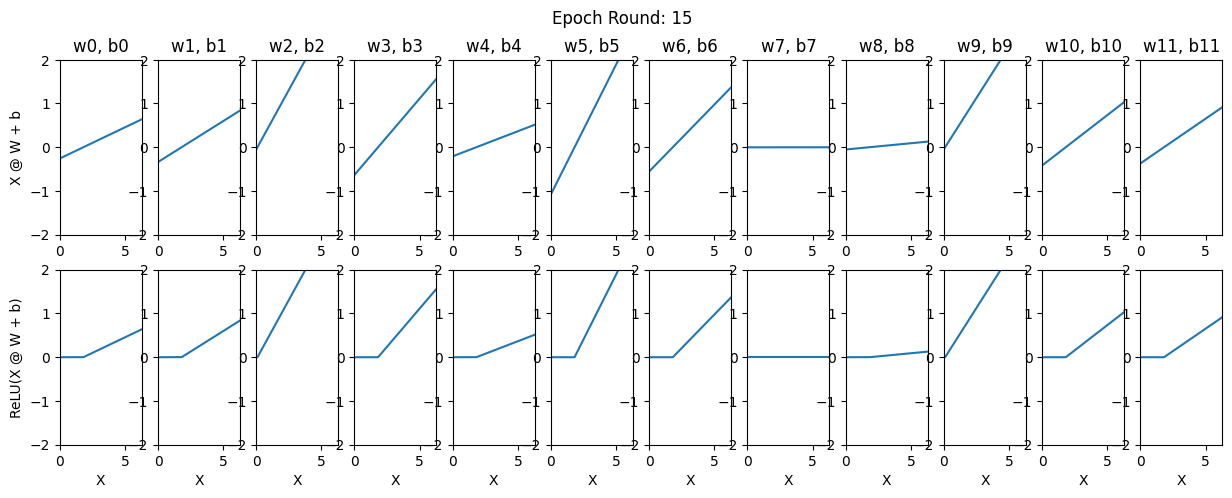

0


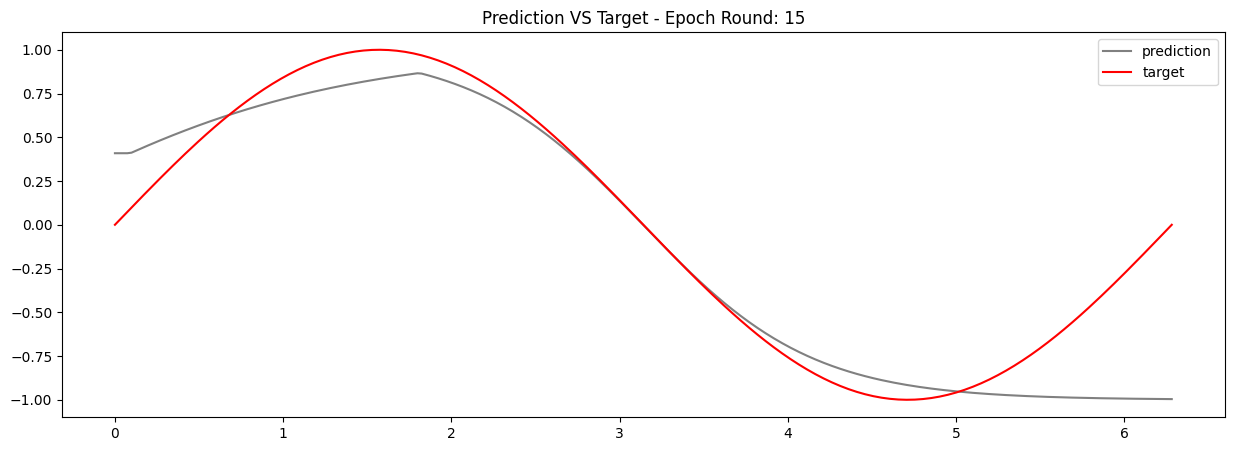

[1024/1024] Loss: 0.06251499056816101


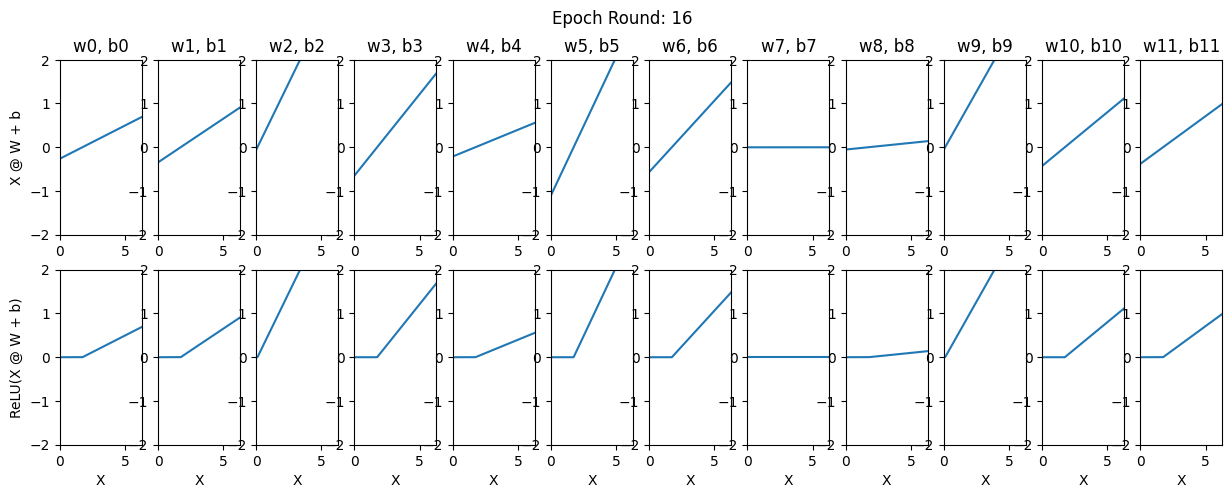

0


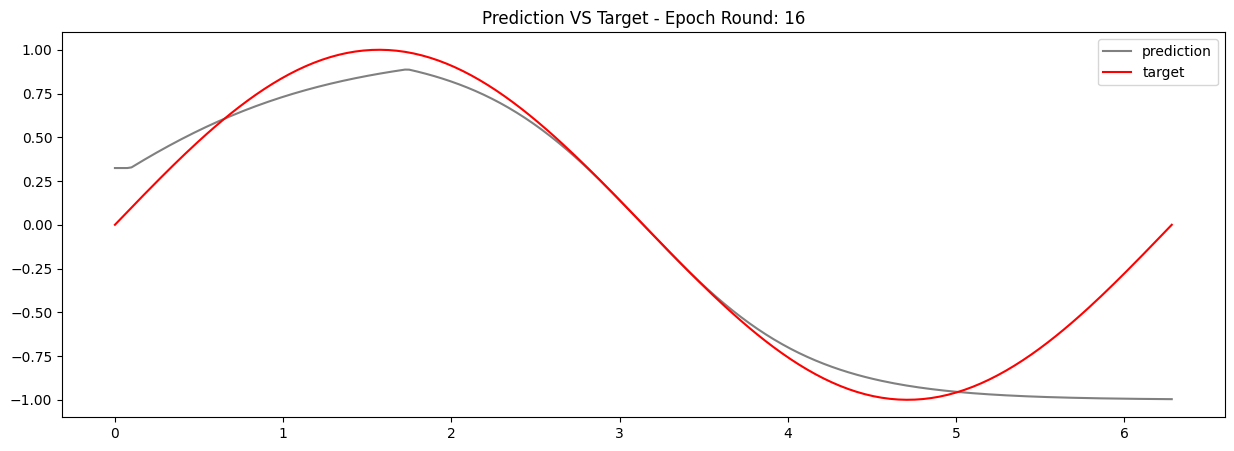

[1024/1024] Loss: 0.06037791445851326


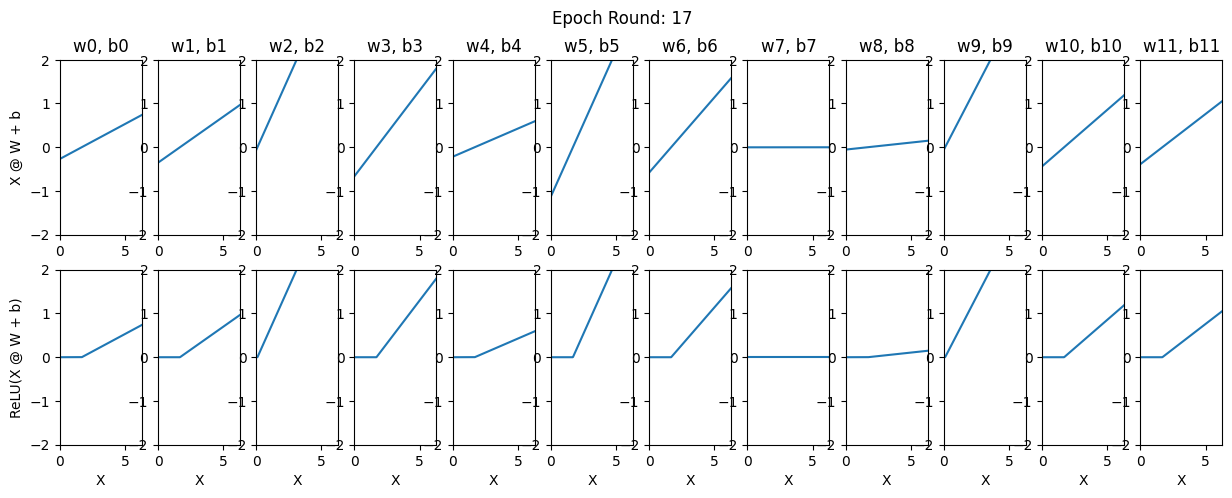

0


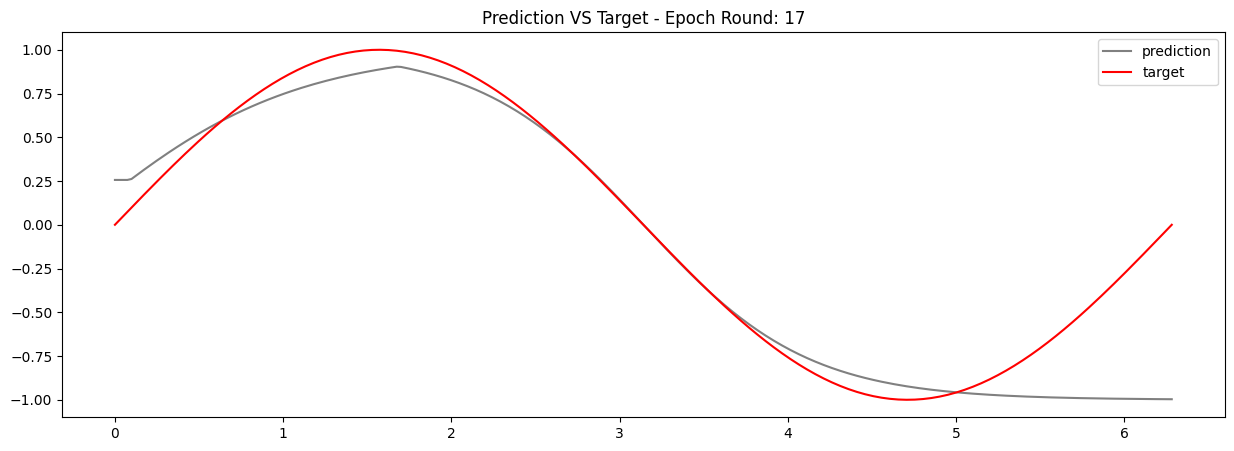

[1024/1024] Loss: 0.05908987671136856


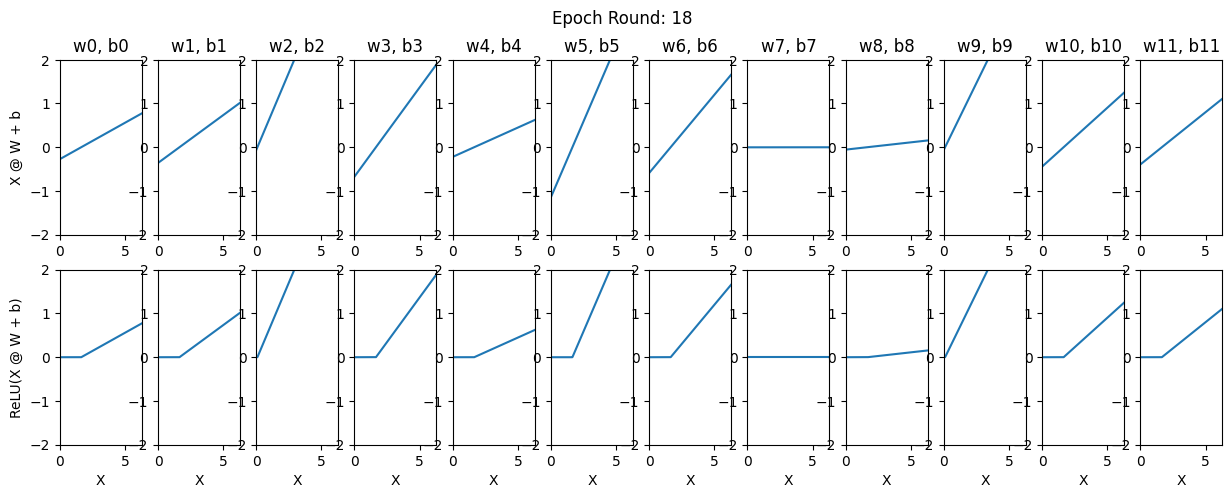

0


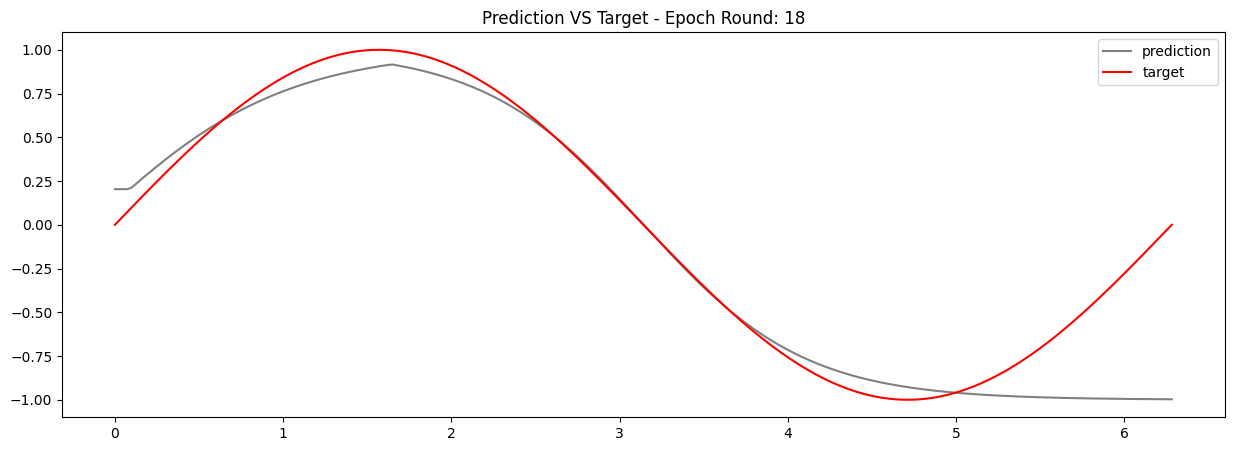

[1024/1024] Loss: 0.058330100029706955


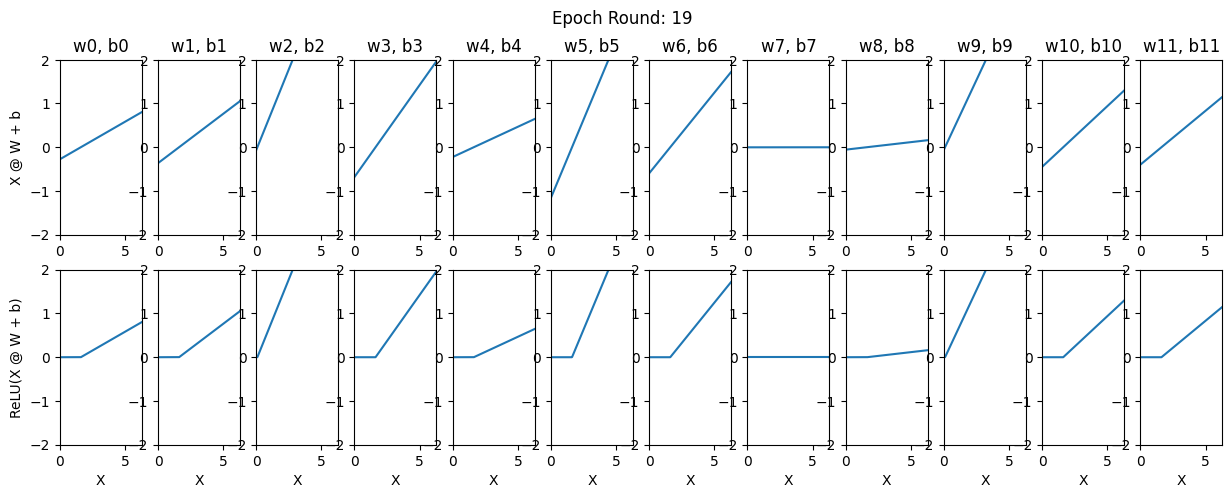

0


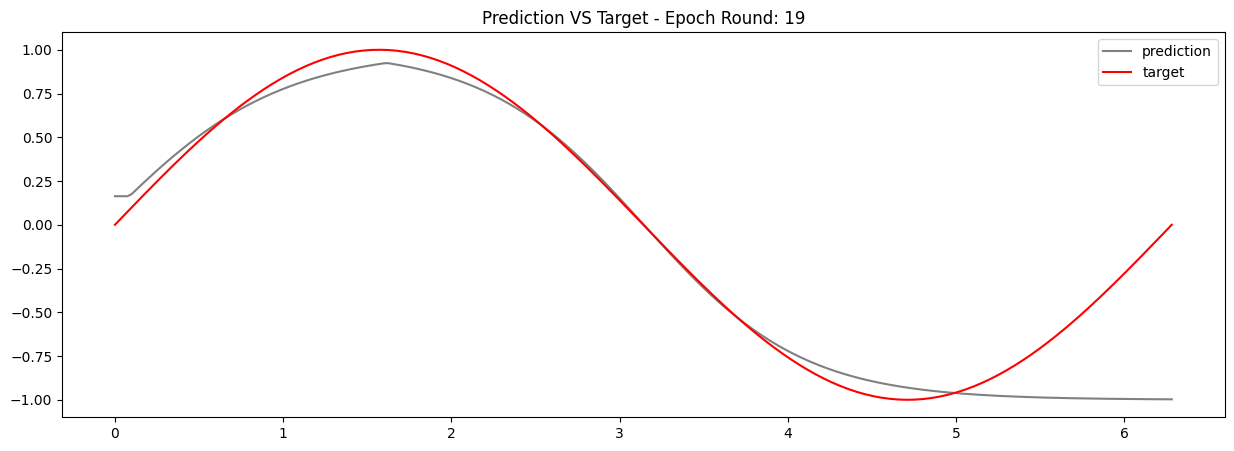

[1024/1024] Loss: 0.057884350419044495


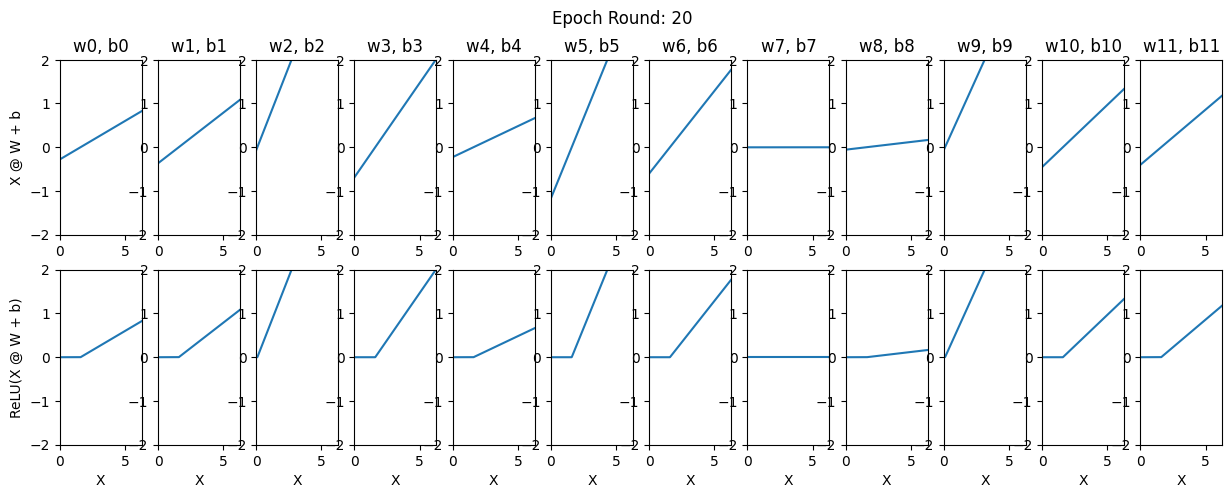

0


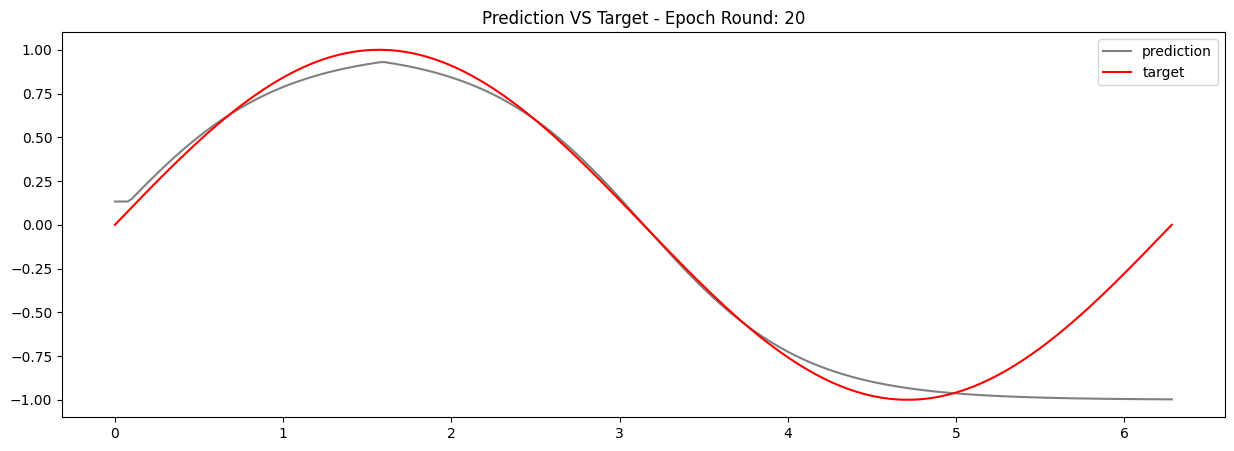

[1024/1024] Loss: 0.05762156471610069


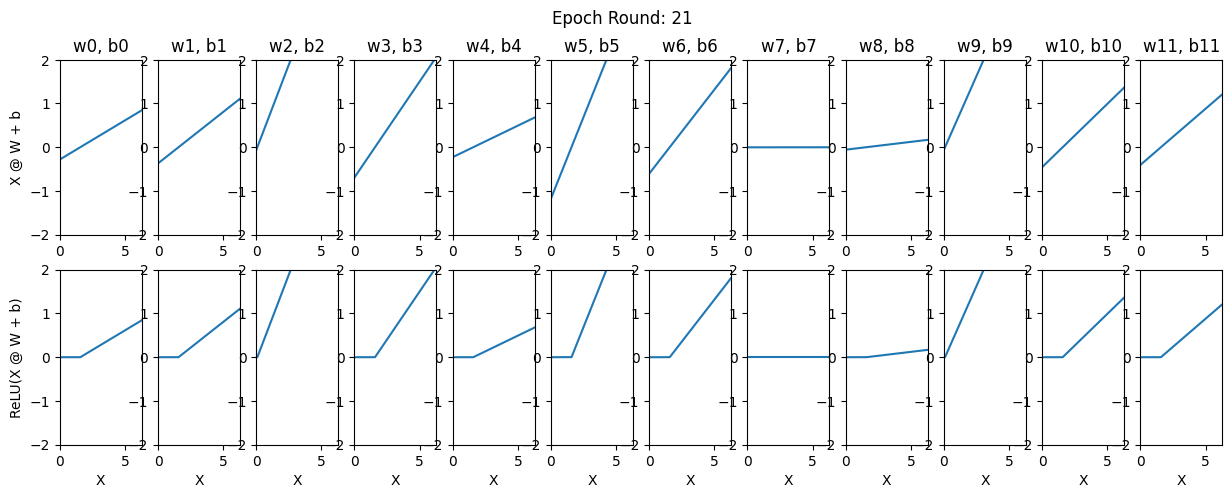

0


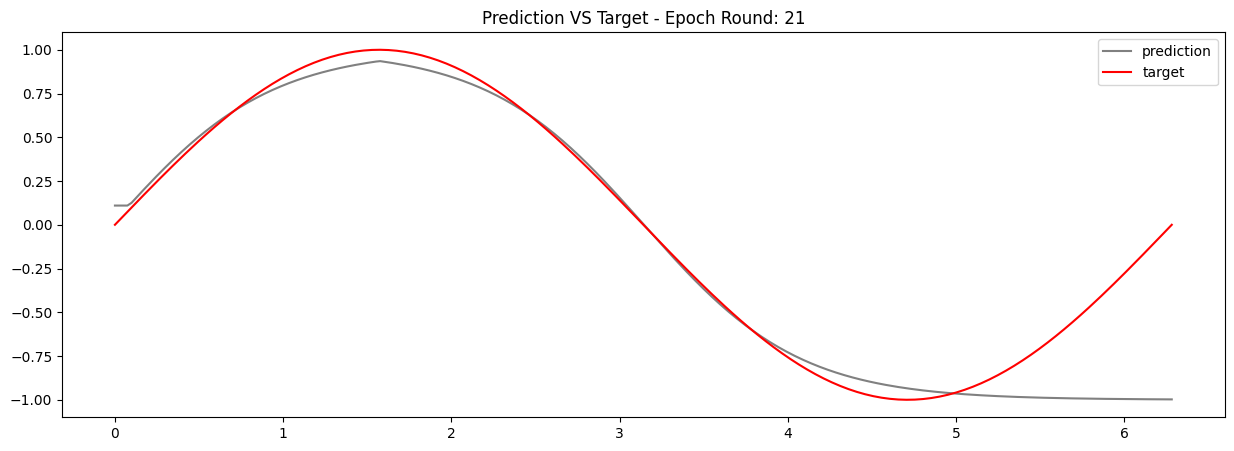

[1024/1024] Loss: 0.057465508580207825


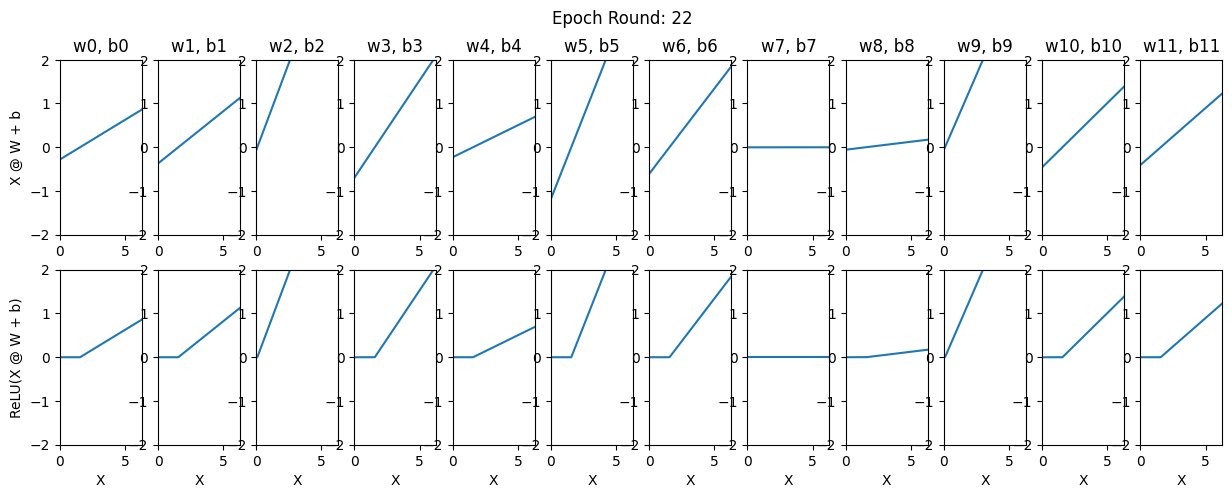

0


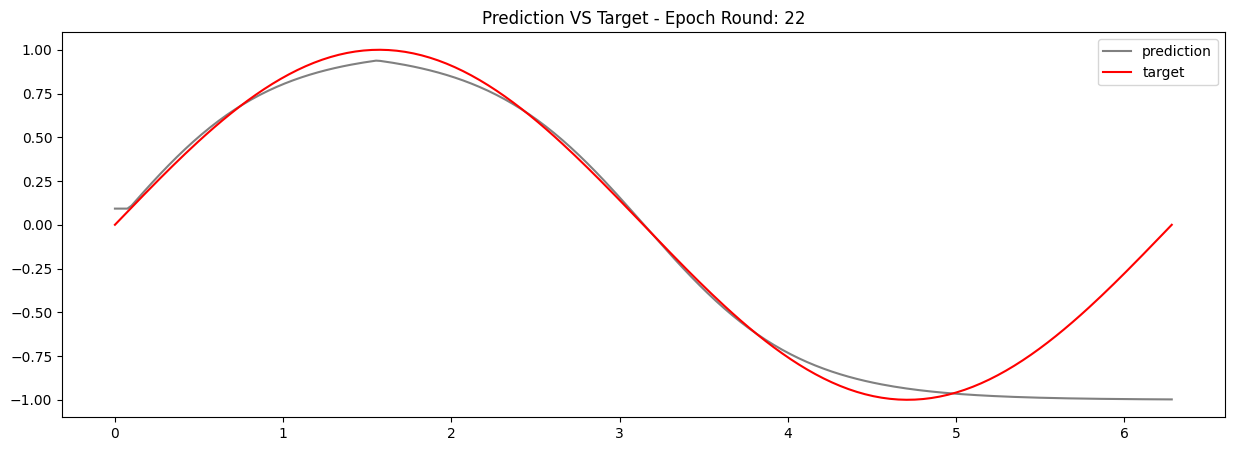

[1024/1024] Loss: 0.057372063398361206


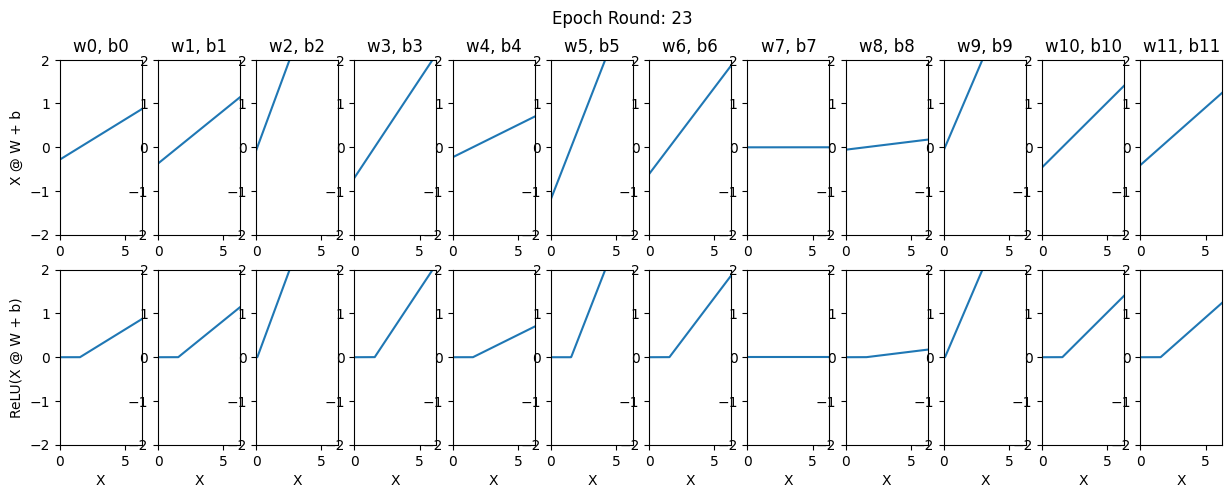

0


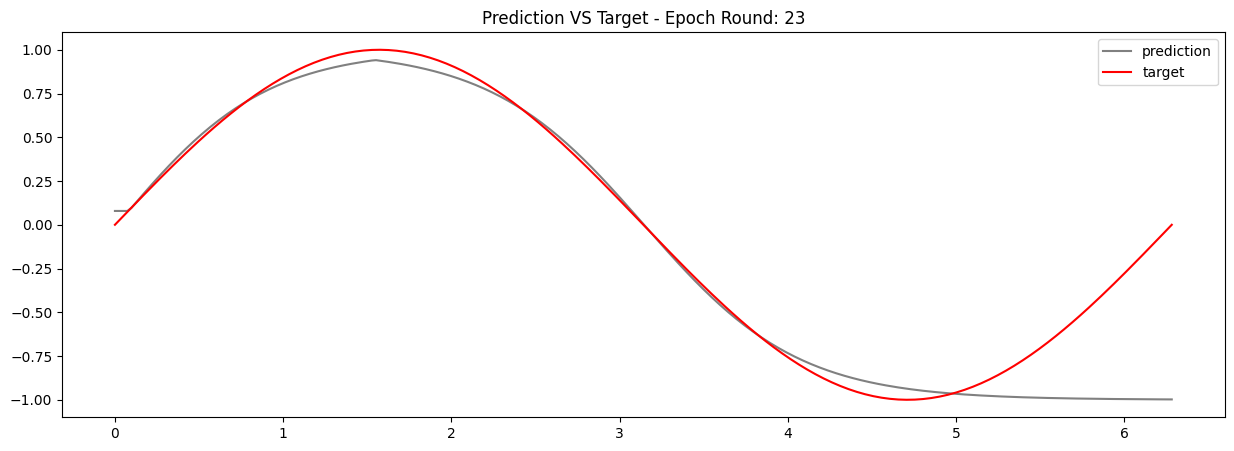

[1024/1024] Loss: 0.057315703481435776


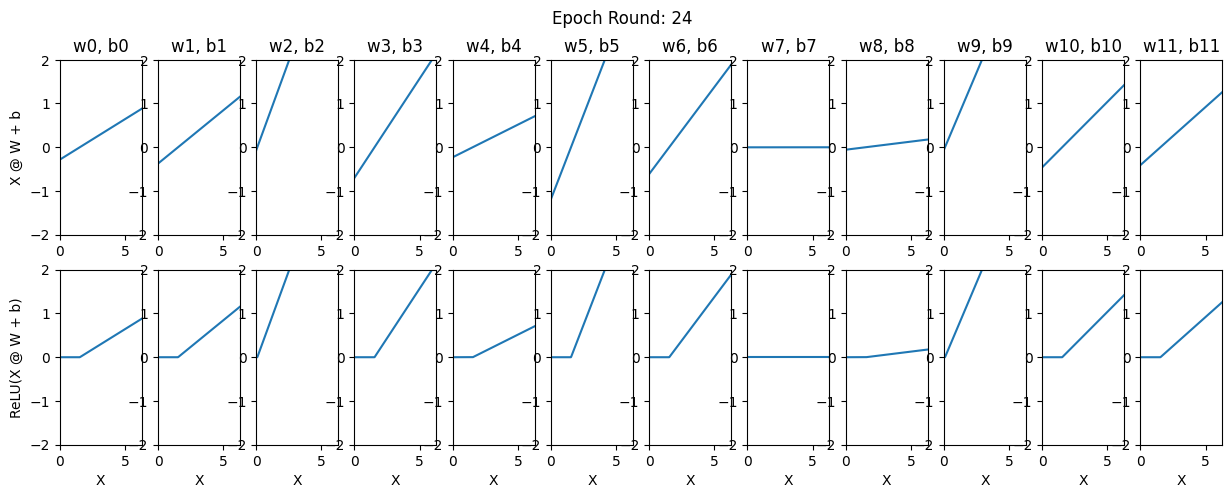

0


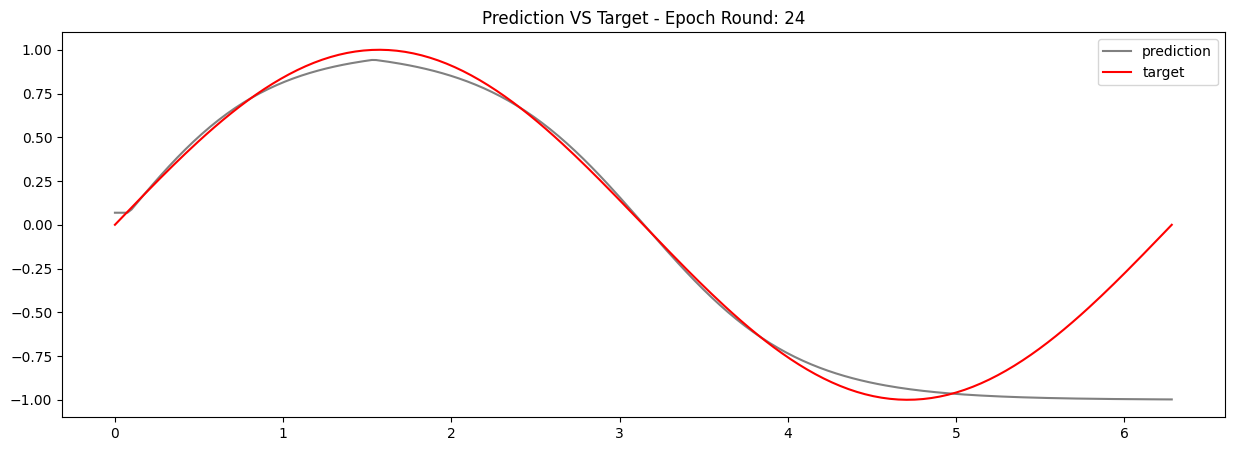

[1024/1024] Loss: 0.057281382381916046


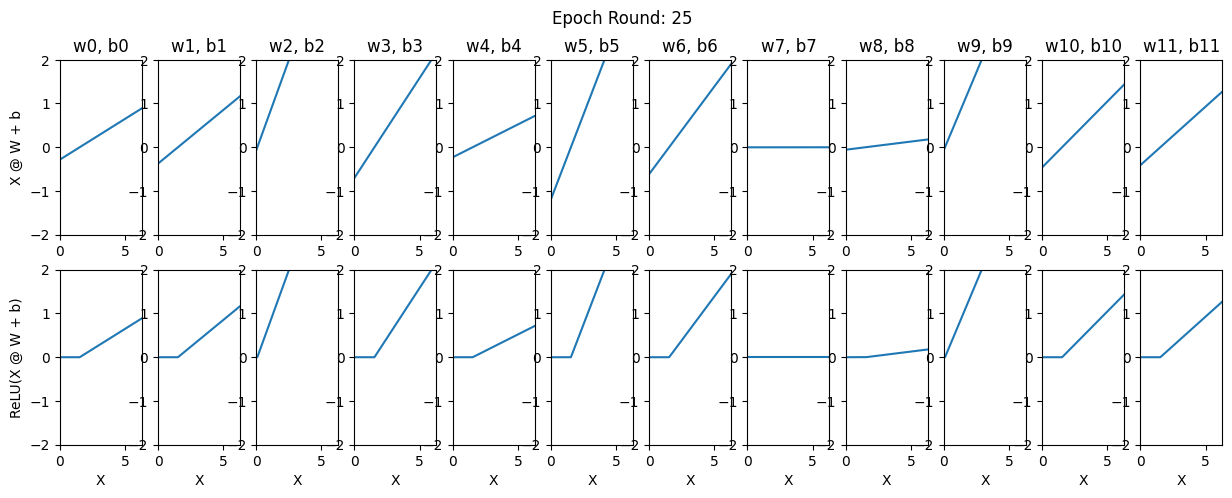

0


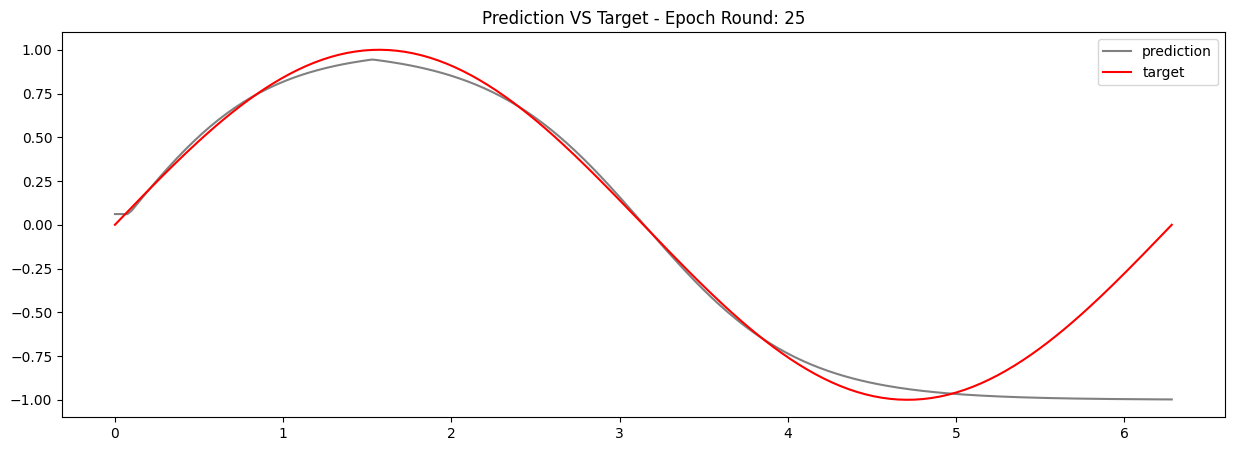

[1024/1024] Loss: 0.05726036801934242


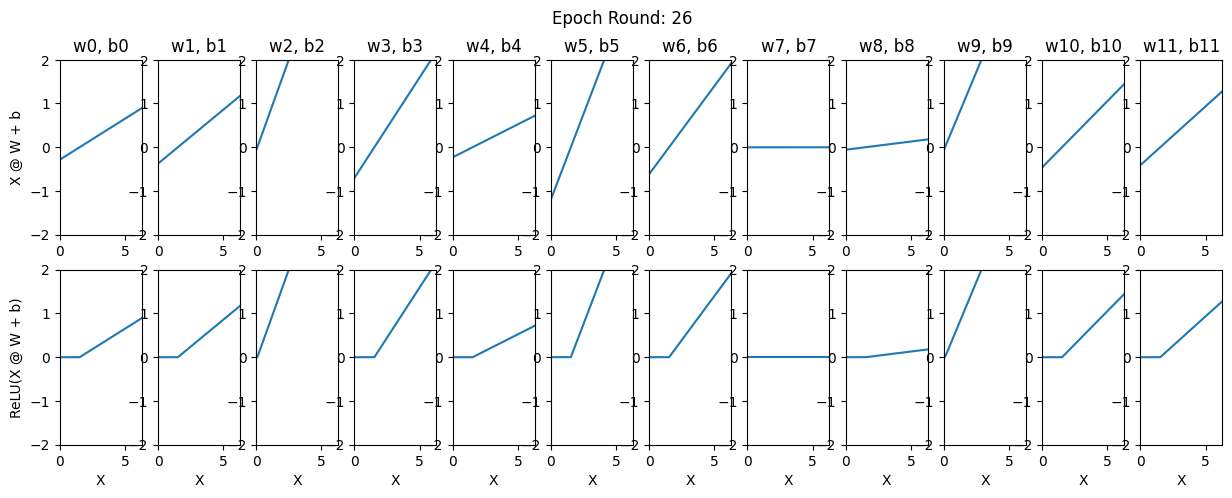

0


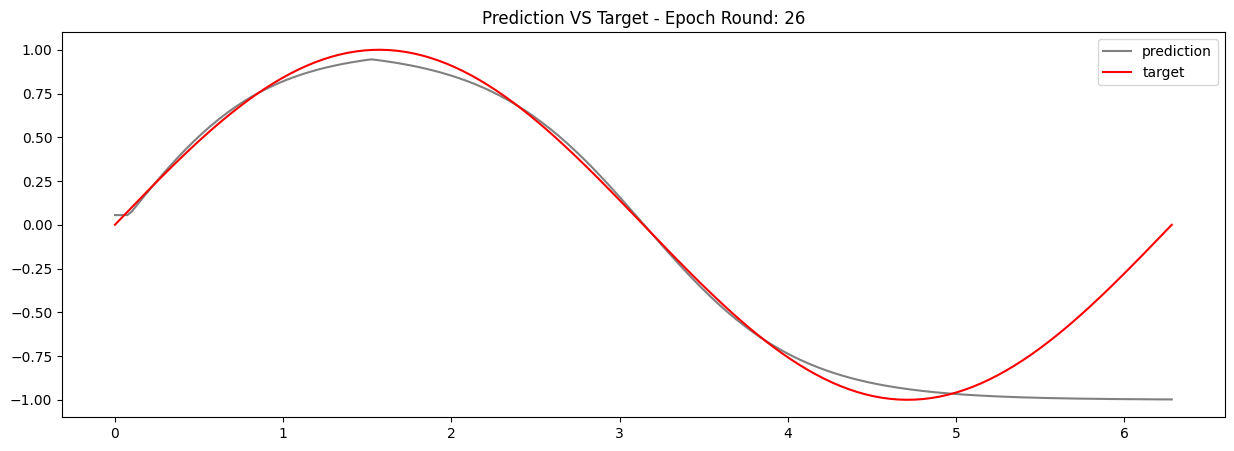

[1024/1024] Loss: 0.057247407734394073


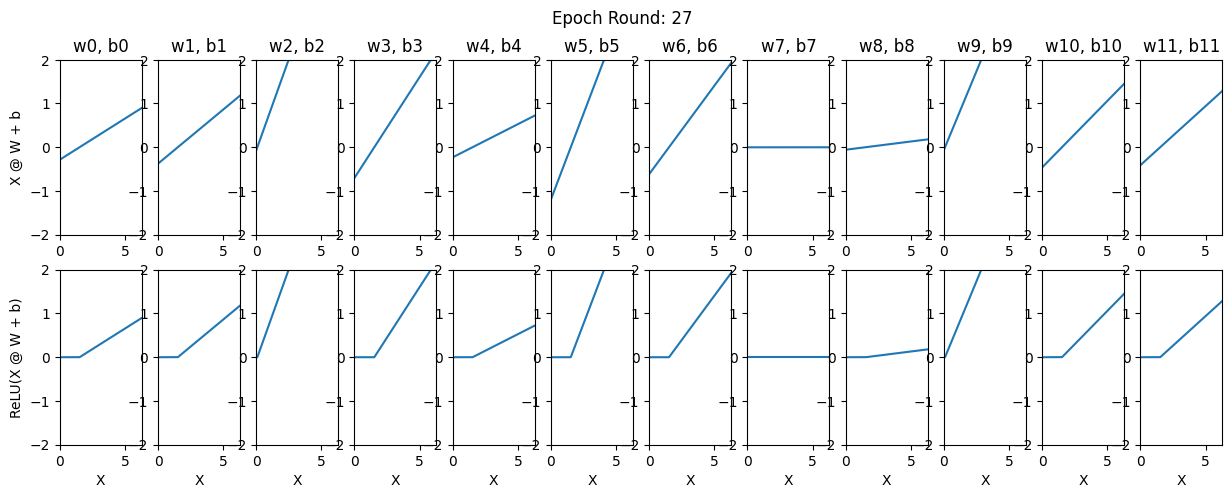

0


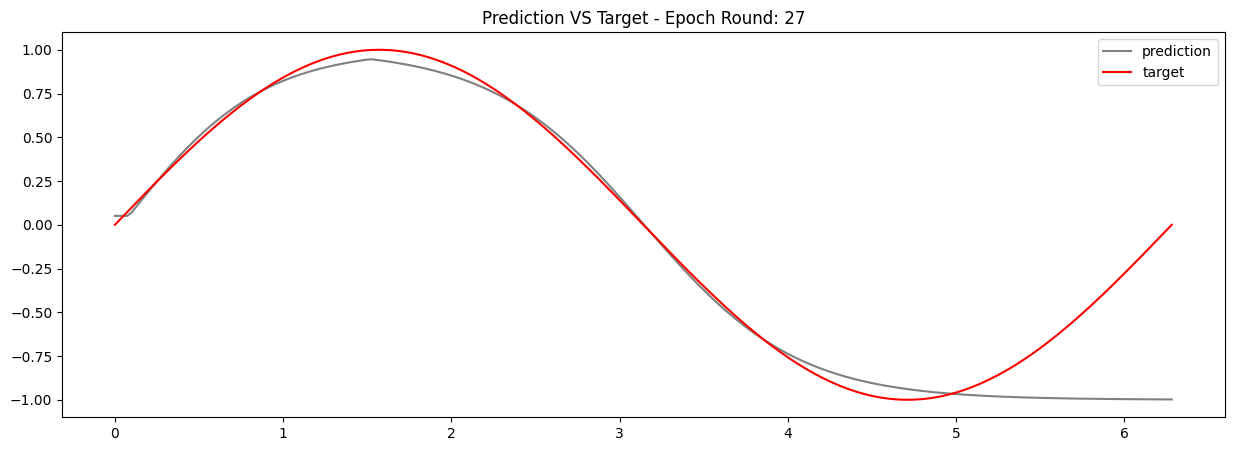

[1024/1024] Loss: 0.0572393424808979


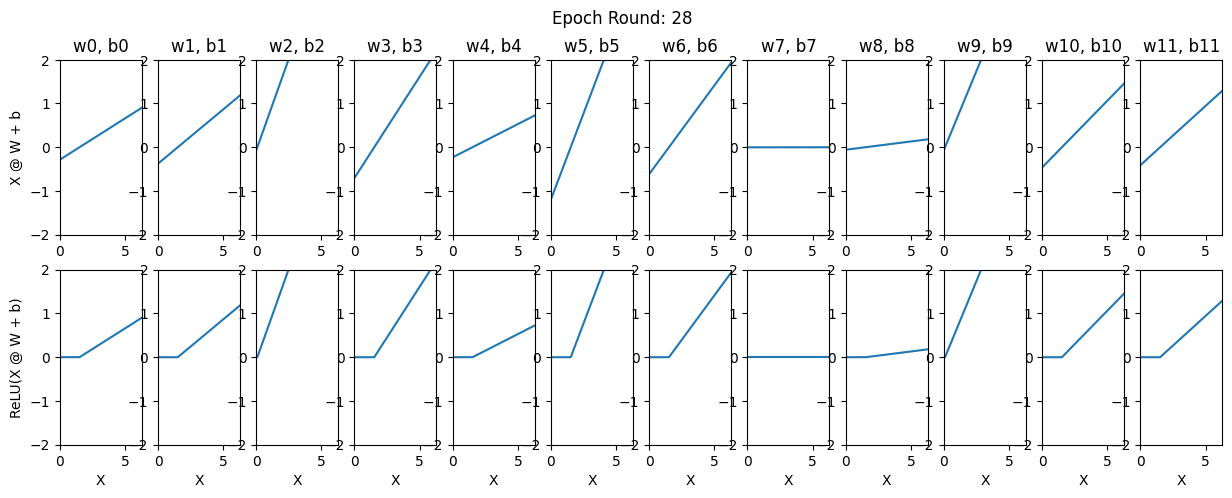

0


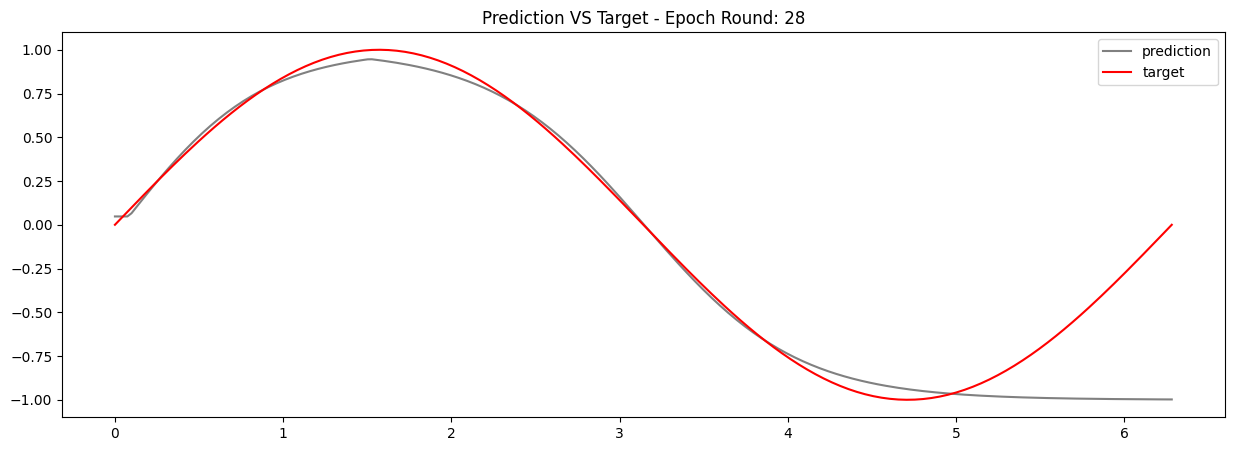

[1024/1024] Loss: 0.05723433196544647


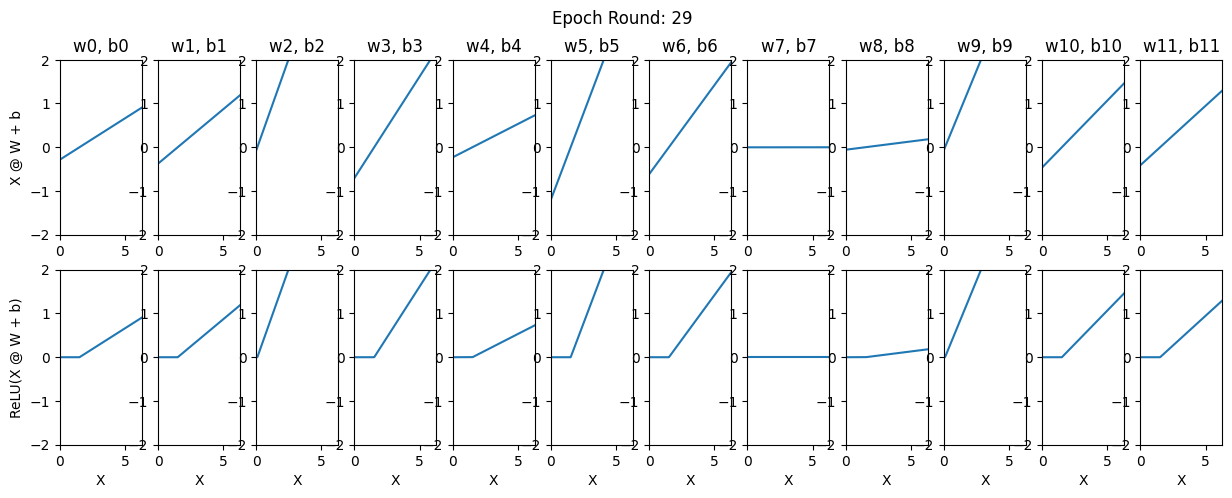

0


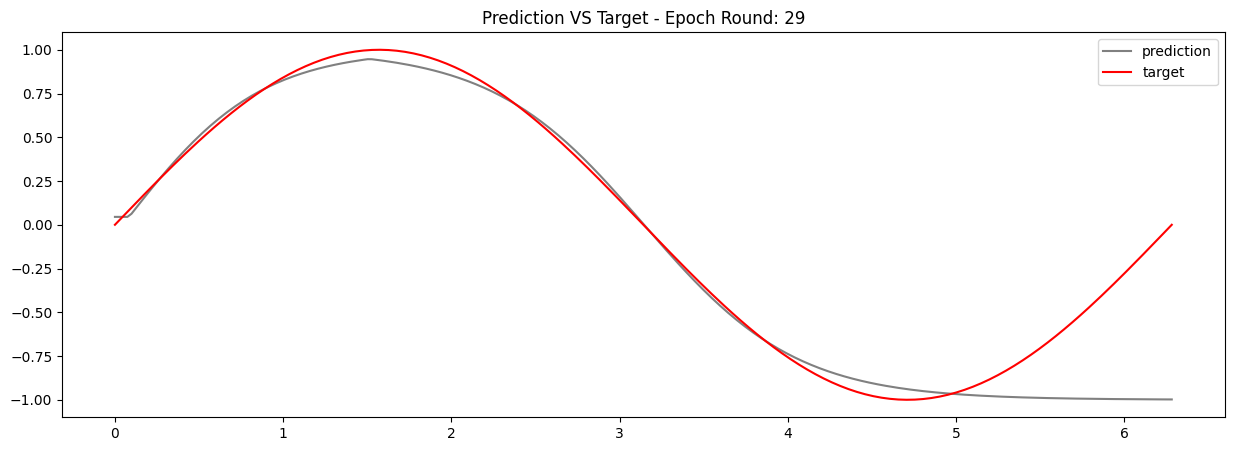

[1024/1024] Loss: 0.05723114311695099


In [52]:
# Network initial parameters
num_hidden = 12
net_sizes = [
  (1, num_hidden),
  (num_hidden, 1),
]

random_seed = np.random.randint(0, 1024)
params = init_network_params(net_sizes, random.PRNGKey(random_seed))

current_epoch = 0
epoch_per_round = 1024
total_epoch_rounds = 30
num_training_samples = 1024
step_display = 1024

for epoch_round in range(1, total_epoch_rounds):
    X_test, y_test = generate_sine_data(256)
    plot_first_activations(params, X_test, y_test,  epoch_round)
    params = train_network(params, num_training_samples, epoch_per_round, step_display)
    # X_test, y_test = generate_sine_data(256)
    # y_pred = predict(params, X_test)
    # loss = loss_func(params, X_test, y_test)
    # print(f'[{epoch_round}]/{total_epoch_rounds} loss = {loss}')
    
     

### Interesting Insights
- Alot of initial weights are not activated per se.

In [40]:
X_test, y_test = generate_sine_data(512)



### Part 1
- Plot each linear component of initial layer.


### Sample Supblot Code

```python

import matplotlib.pyplot as plt


# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting
# Plotting with y-axis limits set

y_min = np.min(y)
y_max = np.max(y)

axs[0].plot(X_flat, y[:, 0], color='green')
axs[0].set_ylim([y_min, y_max])
axs[0].set_title('y = b_00 + w_00 * x')
axs[0].set_xlabel('X input')
axs[0].set_ylabel('y')
axs[0].set_xlim([-1, 1])

axs[1].plot(X_flat, y[:, 1], color='gray')
axs[1].set_ylim([y_min, y_max])
axs[1].set_title('y = b_01 + w_01 * x')
axs[1].set_xlabel('X input')
axs[1].set_xlim([-1, 1])

axs[2].set_xlabel('X input')
axs[2].plot(X_flat, -(y[:, 0] + y[:, 1])/2, color='black')
axs[2].set_ylim([y_min, y_max])
axs[2].set_title('y = b_02 + w_02 * x')
axs[2].set_xlim([-1, 1])

# Display the plot
fig.suptitle('Sublinear Components of Shallow Networks')
plt.show()

```